In [1]:
# Warning: You must have LaTeX installed

[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

# Farnebäck's motion estimation

Farnebäck estimates the dense (1x1) optical flow (with subpixel accuracy) assuming that the frames are similar in texture and the motion is smooth. In general, this last requirement generates motion fields more visually coherent and smoother that in the case of block-based ME algorithms.

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt update
    !apt install imagemagick
    !apt install cm-super
    !apt install dvipng
    !apt install bc
    !apt install texlive-latex-extra
    !apt install texlive-fonts-recommended

In [3]:
!which python

/shared/PEs/opencv-cuda-v2/bin/python


In [4]:
!pip install --upgrade pip

In [5]:
import cv2

In [6]:
try:
    import scipy
except:
    !pip install scipy
    import scipy

In [7]:
try:
    import skimage
except:
    !pip install scikit-image
    import skimage

In [8]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

In [9]:
try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}" #for \text command
   
%matplotlib inline

In [10]:
try:
    from color_transforms import YCoCg as YUV
except:
    !pip install "color_transforms @ git+https://github.com/vicente-gonzalez-ruiz/color_transforms"
    from color_transforms import YCoCg as YUV

In [11]:
try:
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image
except:
    !pip install "image_IO @ git+https://github.com/vicente-gonzalez-ruiz/image_IO"
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image

In [12]:
try:
    from information_theory import information
    #from information_theory import distortion
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    from information_theory import information
    #from information_theory import distortion

In [28]:
try:
    #import optical_flow as motion
    import farneback
    import display
    import predict
except:
    !pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"
    from motion_estimation import farneback
    #import motion_estimation
    #import display
    #import prediction
    #from motion_estimation import optical_flow as motion
    #from motion_estimation import farneback as motion_estimator
    #from motion_estimation import display
    #from motion_estimation import predict

In [14]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [15]:
%%bash
if [ -d "$HOME/repos/image_synthesis" ]; then
    cd $HOME/repos/image_synthesis
    echo "$HOME/repos/image_synthesis ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_synthesis.git
fi

/home/vruiz/repos/image_synthesis ... 
Already up to date.


## Farnebäck basis transform
Farnebäck's algorithm does not compare pixels, but transform coefficients resulting of convolving the following basis fuctions. This decreases the computational requirements the algorithm.

### No motion

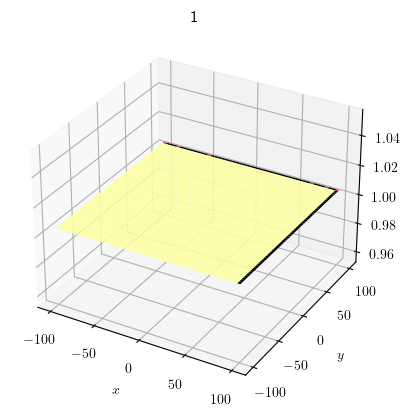

In [16]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = np.sin(tau)**2+np.cos(tau)**2+0.005
ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'1')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the X direction

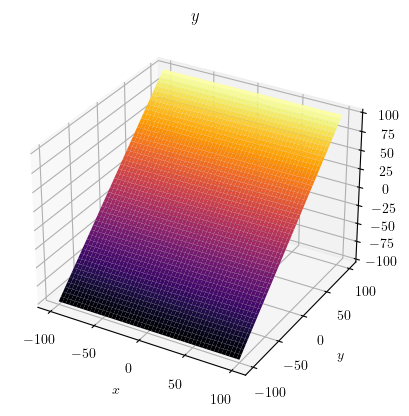

In [17]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp, cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the Y direction

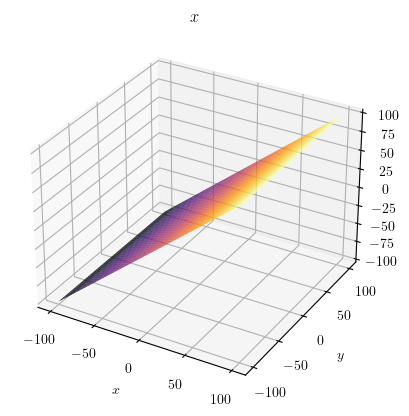

In [18]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Contant motion in both directions (at the same time)

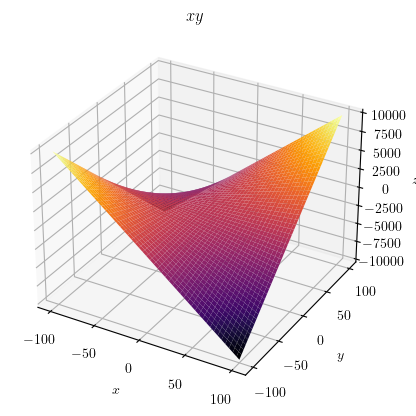

In [19]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$xy$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the Y direction

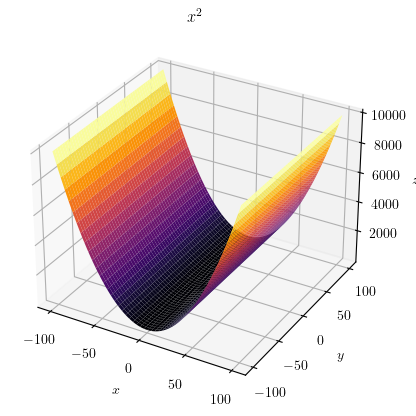

In [20]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the X direction

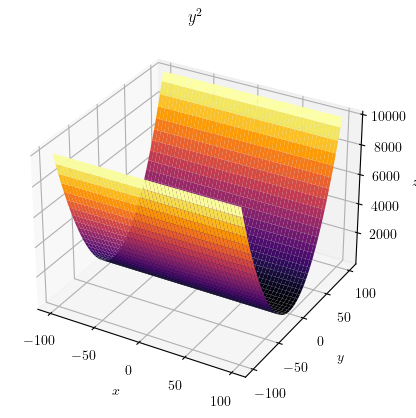

In [21]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

## Create a moving-circles sequence
There are two circles, moving horizontally in oposite directions.

In [22]:
%%bash
frames=5
~/repos/image_synthesis/moving_circle.sh -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f $frames -d 10
~/repos/image_synthesis/moving_circle.sh -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f $frames -d 10 -a 0 -b -1
set -x
i=0
while [ $i -le $((frames-1)) ]
do
    ii=$(printf "%03d" $i)
    convert -append /tmp/right${ii}.png /tmp/left${ii}.png /tmp/${ii}.png
    i=$(( $i + 1 ))
done
set -x

/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f 5 -d 10
output = /tmp/right
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/right000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 33,16 43,16' -depth 8 /tmp/right001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 34,16 44,16' -depth 8 /tmp/right002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 35,16 45,16' -depth 8 /tmp/right003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 36,16 46,16' -depth 8 /tmp/right004.png
+ i=5
+ '[' 5 -le 4 ']'


/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f 5 -d 10 -a 0 -b -1
output = /tmp/left
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10
Y increment = 0
X increment = -1


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/left000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 31,16 41,16' -depth 8 /tmp/left001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 30,16 40,16' -depth 8 /tmp/left002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 29,16 39,16' -depth 8 /tmp/left003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 28,16 38,16' -depth 8 /tmp/left004.png
+ i=5
+ '[' 5 -le 4 ']'
+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -append /tmp/right000.png /tmp/left000.png /tmp/000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001


## Testing with moving circles (max_abs_motion=1)

In [23]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/001.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=672 max=255 min=0
[image_3.py:39 read() INFO] /tmp/001.png (64, 64, 3) uint8 len=672 max=255 min=0


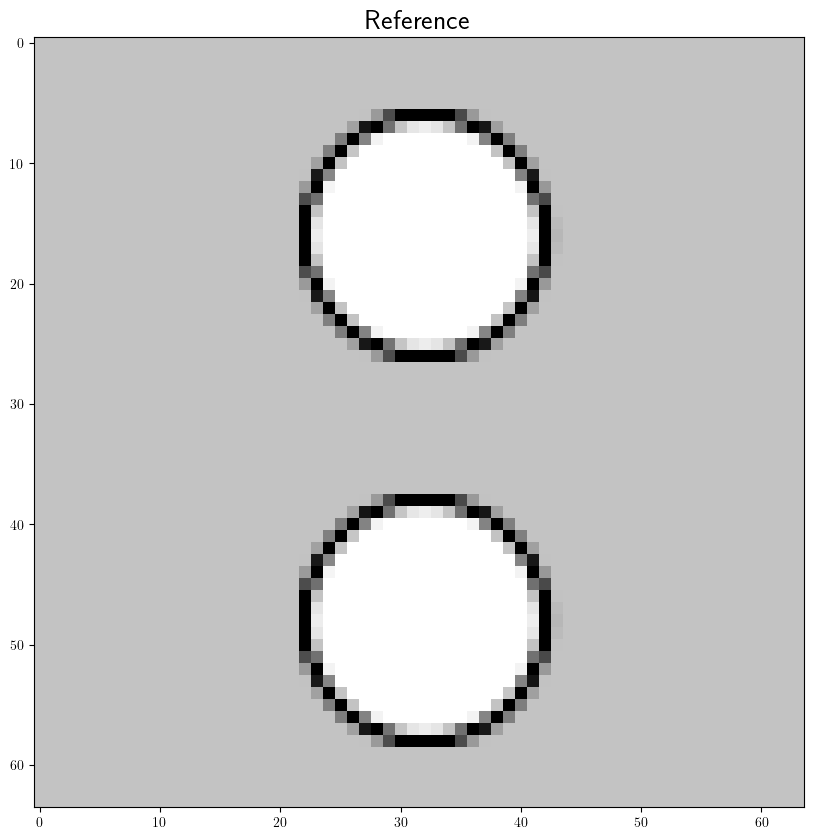

In [24]:
gray_image.show(R_Y, "Reference")

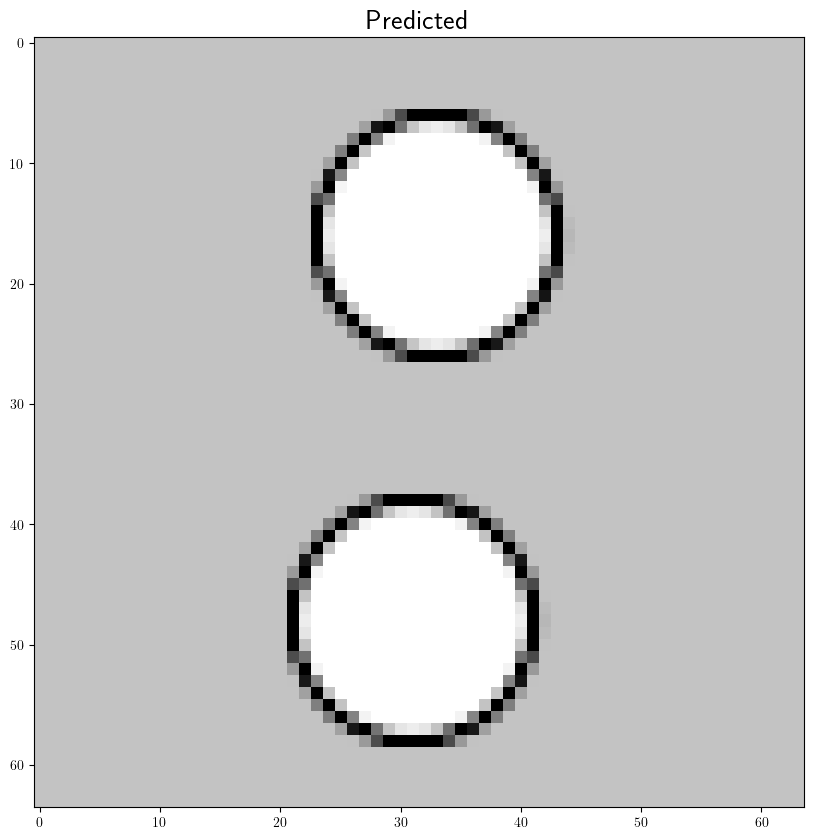

In [25]:
gray_image.show(P_Y, "Predicted")

The top circle moves to the right and the bottom circle moves to the left. Therefore, if we want to generate the predicted frame (bottom) from the reference one (top), all the top MVs (Motion Vectors) related to the circle should be (x=1, y=0), and all the bottom MVs (-1, 0).

In [26]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
estimator = farneback.Estimator_in_CPU()
MVs = estimator.get_flow(target=P_Y, reference=R_Y, prev_flow=initial_MVs)
#MVs = motionestimation.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

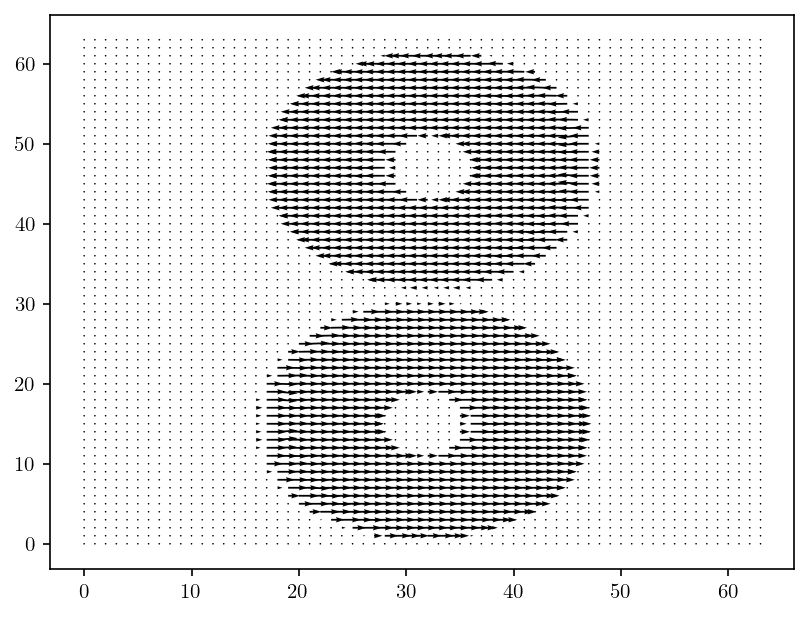

In [29]:
display.show_vectors(MVs[::1, ::1])

In [32]:
hat_P = predict.warp(reference=R, flow=MVs)

In [33]:
print(R.dtype, MVs.dtype)

uint8 float32


[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.75390625
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.47607421875
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.46240234375
[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.75390625
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.47607421875
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.46240234375
[image_3.py:87 print_stats() INFO] component=0 max=128 min=128 avg=128.0
[image_3.py:87 print_stats() INFO] component=1 max=128 min=128 avg=128.0
[image_3.py:87 print_stats() INFO] component=2 max=128 min=128 avg=128.0


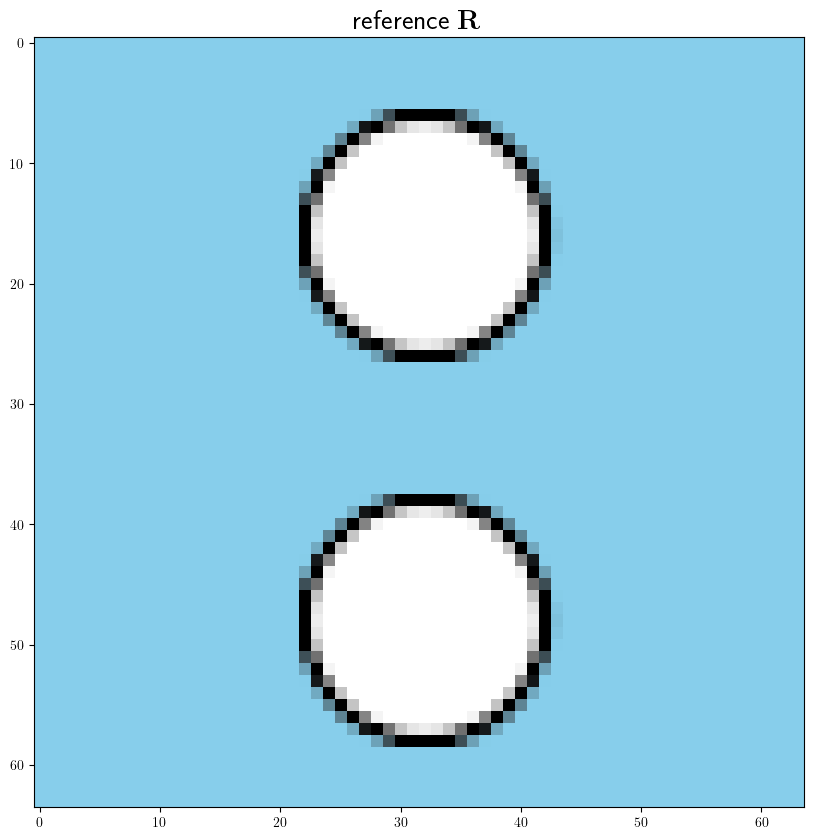

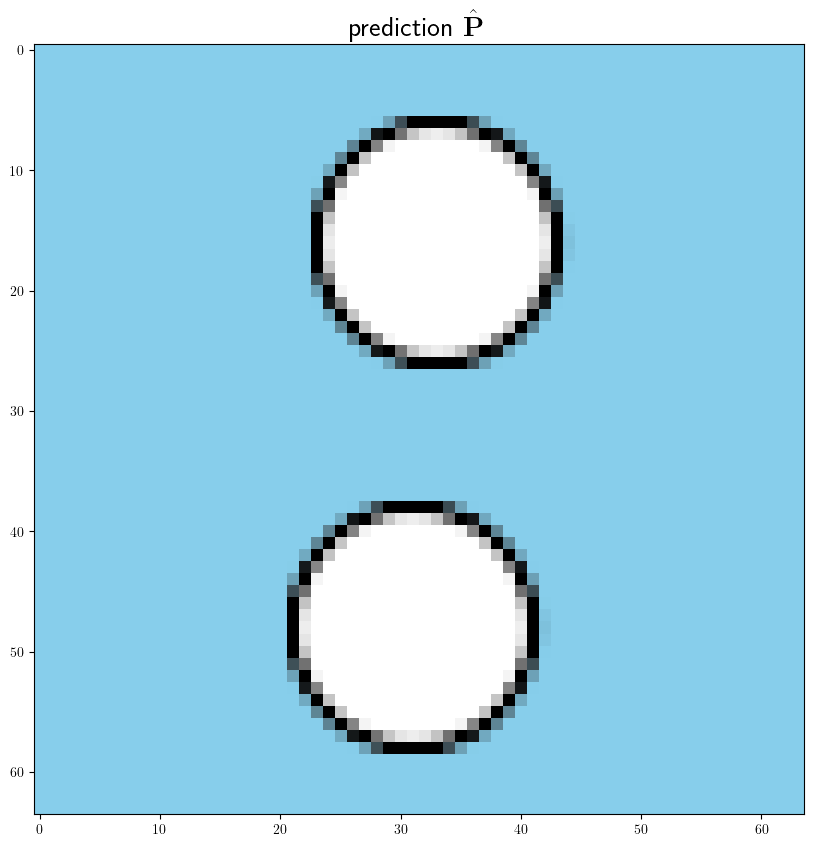

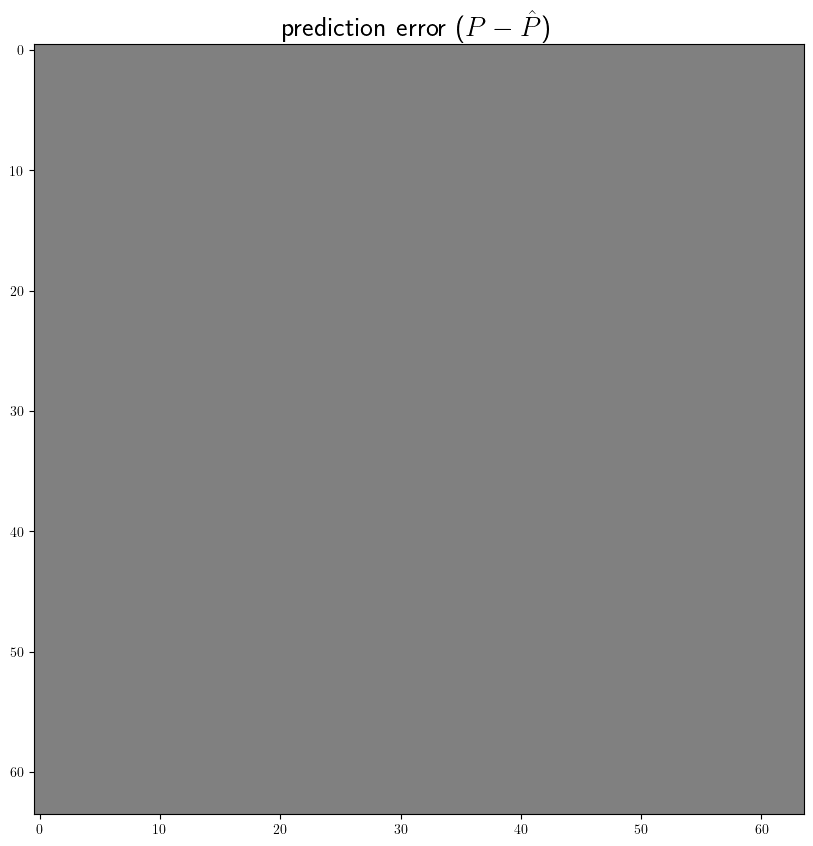

In [34]:
RGB_image.show(R, "reference ${\mathbf R}$")
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Testing with moving circles (max_abs_motion=2)

In [35]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/002.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=672 max=255 min=0
[image_3.py:39 read() INFO] /tmp/002.png (64, 64, 3) uint8 len=672 max=255 min=0


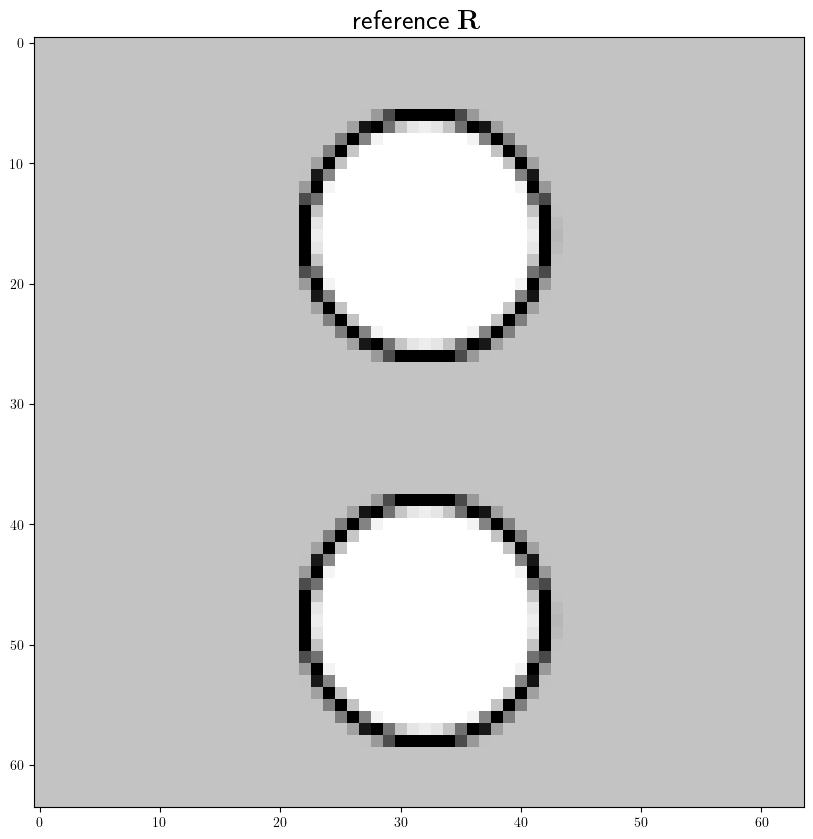

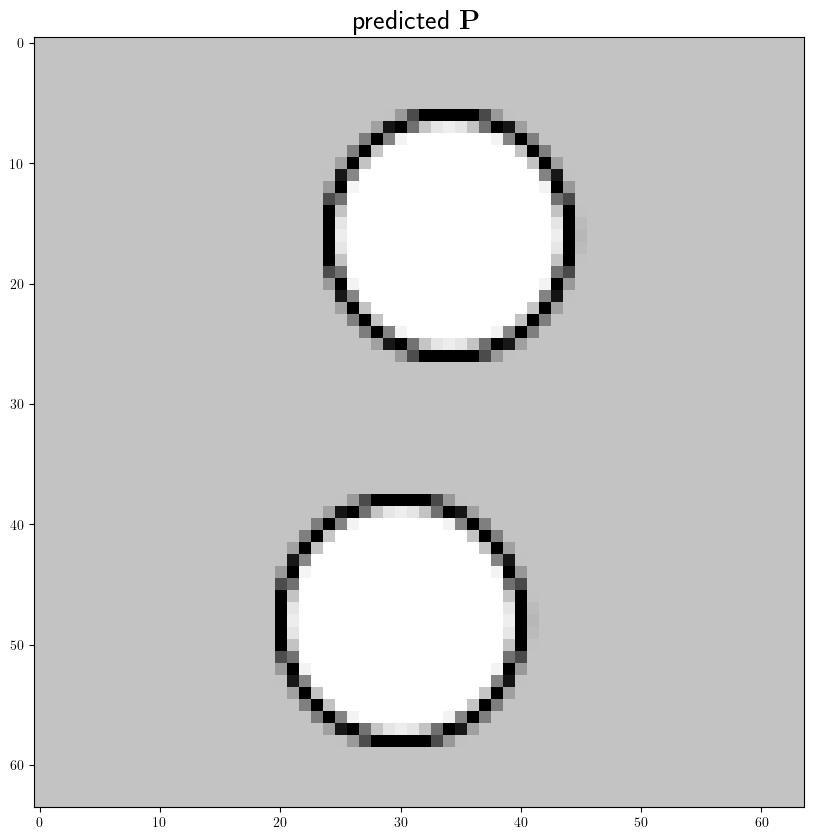

In [36]:
gray_image.show(R_Y, "reference ${\mathbf R}$")
gray_image.show(P_Y, "predicted ${\mathbf P}$")

In [37]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#estimator = farneback.Estimator_in_CPU()
MVs = estimator.get_flow(target=P_Y, reference=R_Y, prev_flow=initial_MVs)

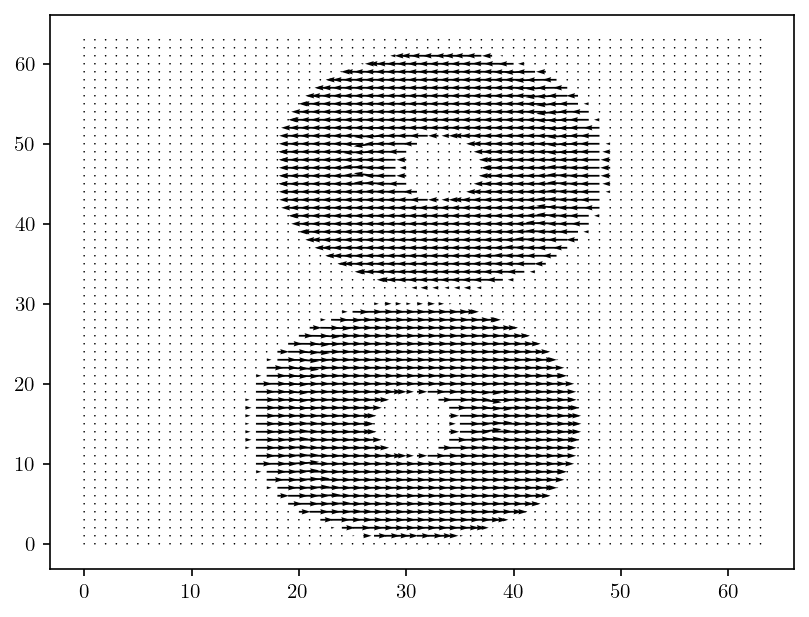

In [38]:
display.show_vectors(MVs[::1, ::1])

[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.75390625
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.47607421875
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.46240234375
[image_3.py:87 print_stats() INFO] component=0 max=128 min=128 avg=128.0
[image_3.py:87 print_stats() INFO] component=1 max=128 min=128 avg=128.0
[image_3.py:87 print_stats() INFO] component=2 max=128 min=128 avg=128.0


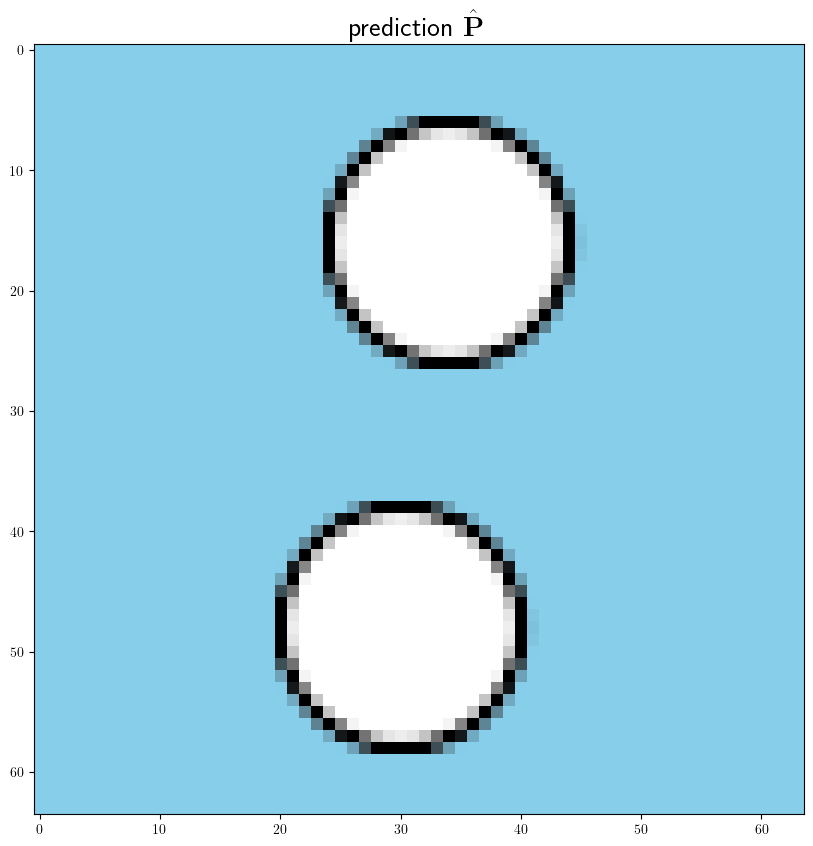

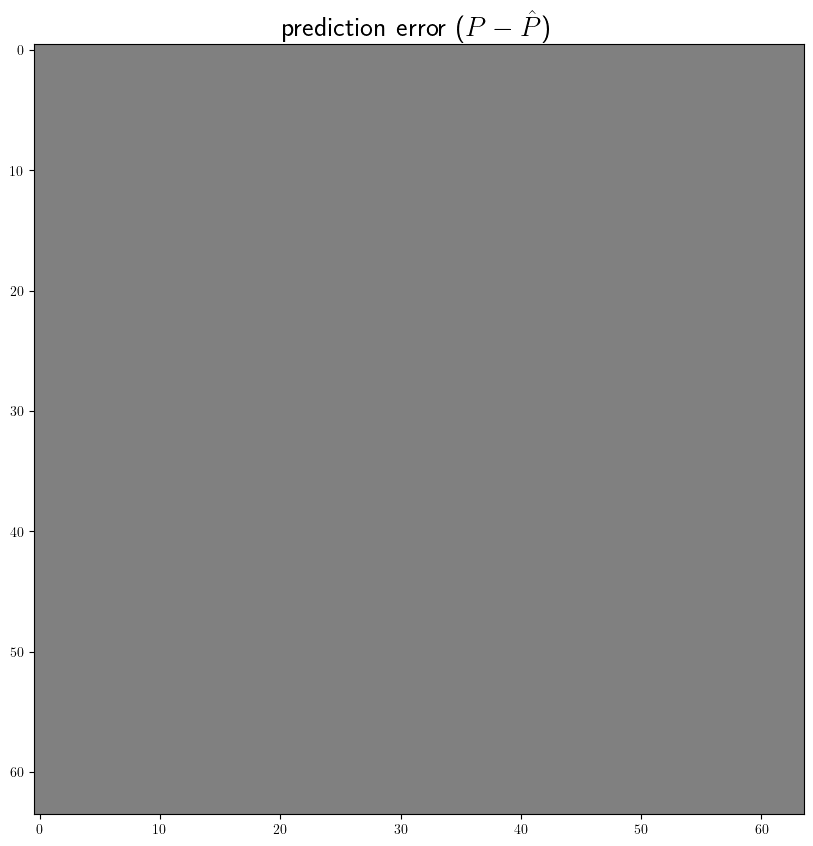

In [39]:
hat_P = predict.warp(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Even more distance

In [40]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/004.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=672 max=255 min=0
[image_3.py:39 read() INFO] /tmp/004.png (64, 64, 3) uint8 len=672 max=255 min=0


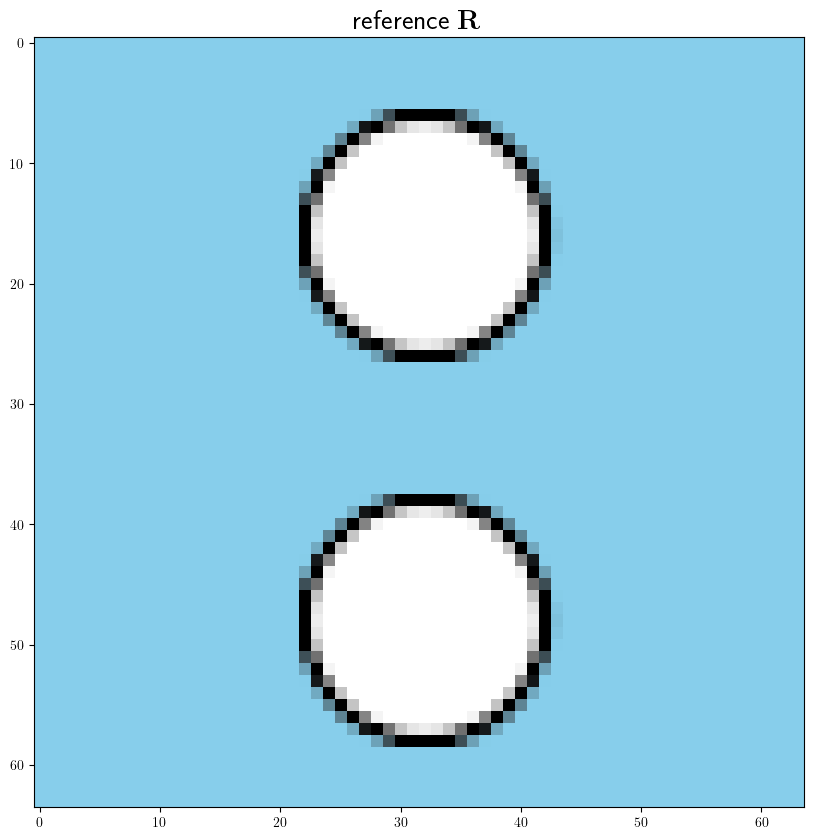

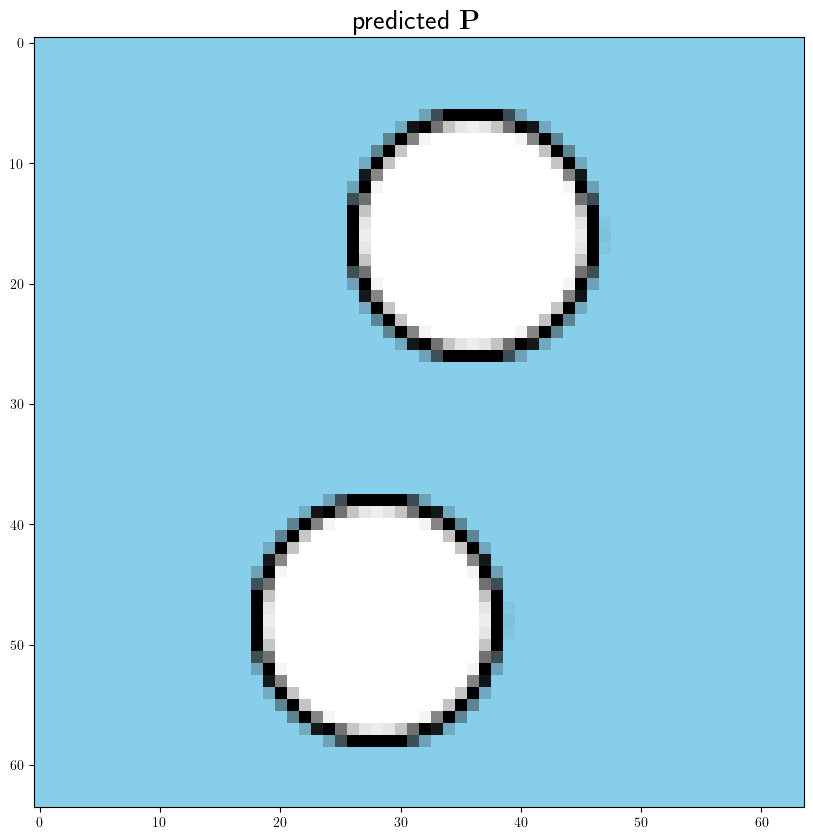

In [41]:
gray_image.show(R, "reference ${\mathbf R}$")
gray_image.show(P, "predicted ${\mathbf P}$")

In [42]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#estimator = farneback.Estimator_in_CPU()
MVs = estimator.get_flow(target=P_Y, reference=R_Y, prev_flow=initial_MVs)

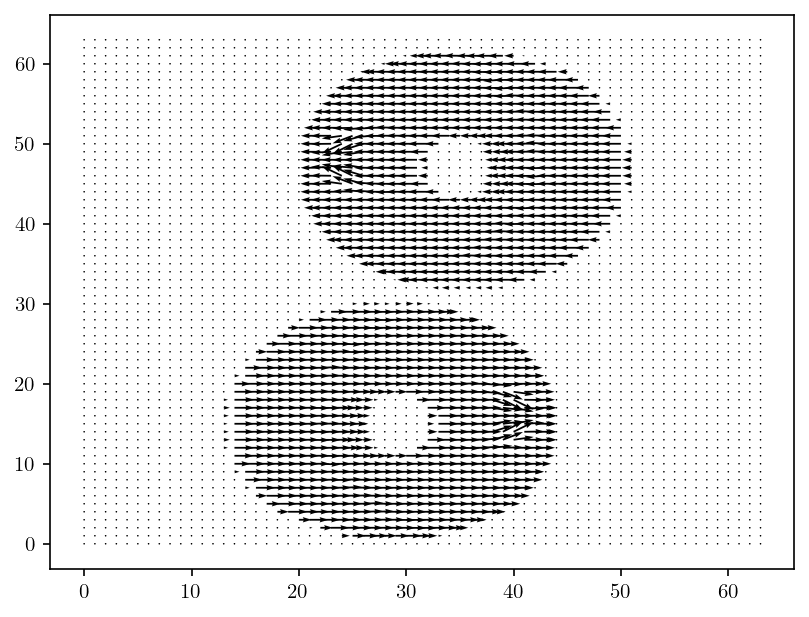

In [43]:
display.show_vectors(MVs[::1, ::1])

[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.75390625
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.47607421875
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.46240234375
[image_3.py:87 print_stats() INFO] component=0 max=128 min=128 avg=128.0
[image_3.py:87 print_stats() INFO] component=1 max=128 min=128 avg=128.0
[image_3.py:87 print_stats() INFO] component=2 max=128 min=128 avg=128.0


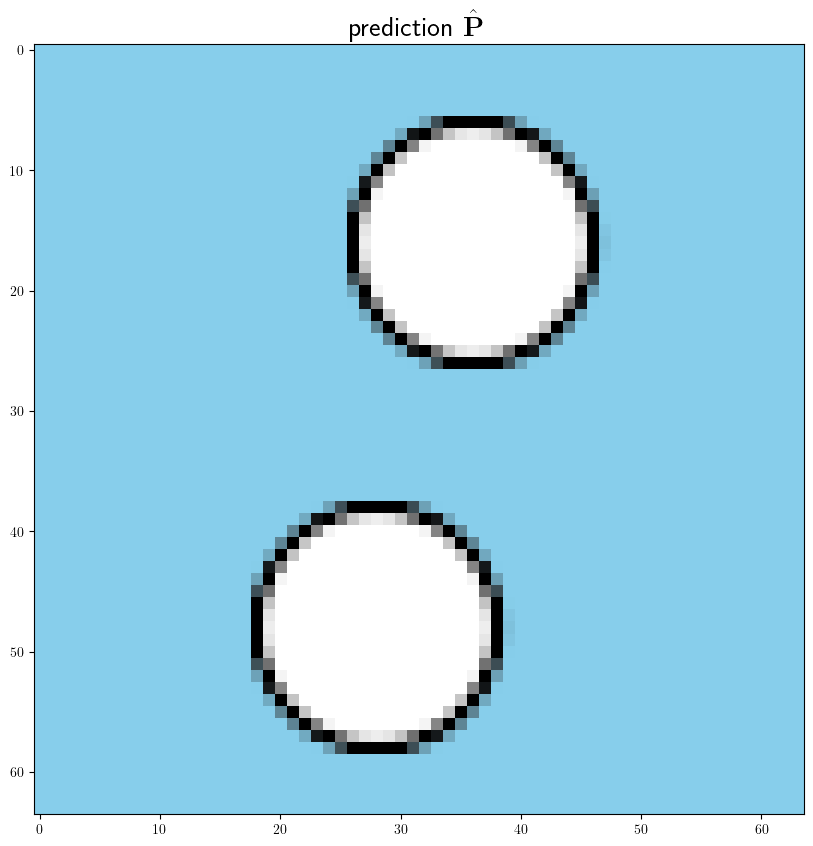

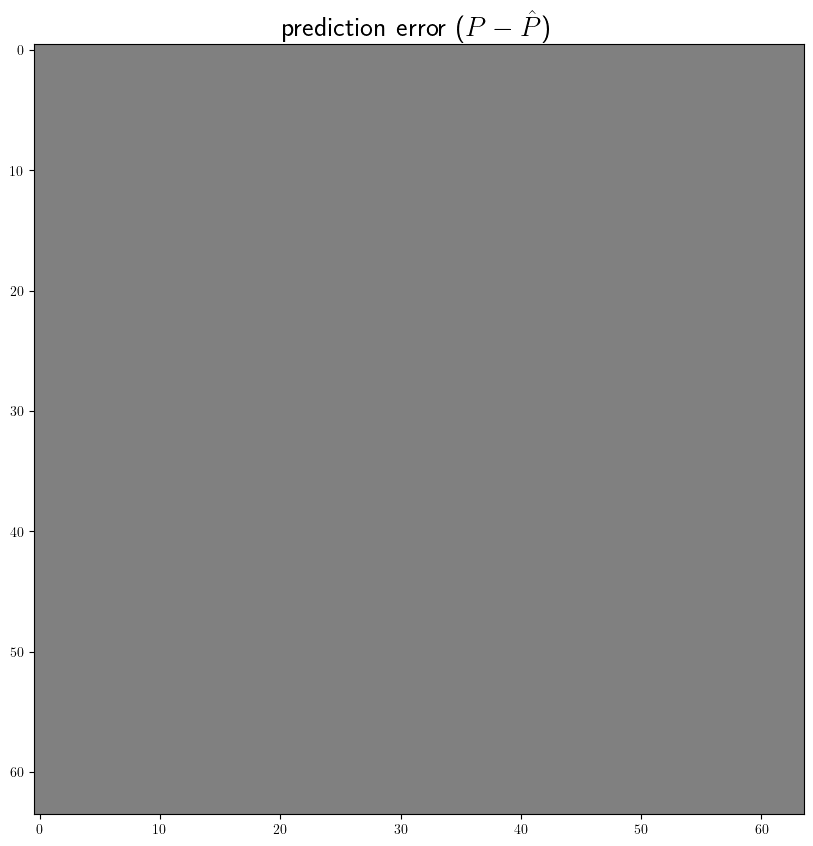

In [44]:
hat_P = predict.warp(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

### Conclusion
Farnebäck's ME does not always minimizes the L$_2$ distance.

## Tile of Stockholm

In [ ]:
%%bash
URL="https://hpca.ual.es/~vruiz/videos/"
sequence="stockholm_1280x768x50x420x578.avi"
output_prefix="/tmp/original_"
number_of_frames=16
first_frame=2
~/repos/image_synthesis/extract_frames.sh -u $URL -s $sequence -o $output_prefix -n $number_of_frames -f $first_frame

 21150K .......... .......... .......... .......... ..........  6% 21,3M 26s
 21200K .......... .......... .......... .......... ..........  6% 20,5M 26s
 21250K .......... .......... .......... .......... ..........  6% 12,8M 26s
 21300K .......... .......... .......... .......... ..........  6% 21,8M 25s
 21350K .......... .......... .......... .......... ..........  6% 13,0M 25s
 21400K .......... .......... .......... .......... ..........  6% 26,3M 25s
 21450K .......... .......... .......... .......... ..........  6% 13,9M 25s
 21500K .......... .......... .......... .......... ..........  6% 20,8M 25s
 21550K .......... .......... .......... .......... ..........  6% 17,6M 25s
 21600K .......... .......... .......... .......... ..........  6% 8,80M 25s
 21650K .......... .......... .......... .......... ..........  6% 30,6M 25s
 21700K .......... .......... .......... .......... ..........  6% 15,0M 25s
 21750K .......... .......... .......... .......... ..........  6% 25,3M 25s

 26500K .......... .......... .......... .......... ..........  7%  418M 24s
 26550K .......... .......... .......... .......... ..........  7% 10,7M 24s
 26600K .......... .......... .......... .......... ..........  7% 27,6M 24s
 26650K .......... .......... .......... .......... ..........  7% 10,8M 24s
 26700K .......... .......... .......... .......... ..........  7% 43,2M 24s
 26750K .......... .......... .......... .......... ..........  7% 13,8M 24s
 26800K .......... .......... .......... .......... ..........  7% 27,1M 24s
 26850K .......... .......... .......... .......... ..........  7% 14,8M 24s
 26900K .......... .......... .......... .......... ..........  7% 25,8M 24s
 26950K .......... .......... .......... .......... ..........  7% 10,9M 24s
 27000K .......... .......... .......... .......... ..........  7% 47,8M 24s
 27050K .......... .......... .......... .......... ..........  7% 9,01M 24s
 27100K .......... .......... .......... .......... ..........  7% 30,4M 24s

 31850K .......... .......... .......... .......... ..........  9% 10,3M 23s
 31900K .......... .......... .......... .......... ..........  9% 28,9M 23s
 31950K .......... .......... .......... .......... ..........  9% 15,0M 23s
 32000K .......... .......... .......... .......... ..........  9% 11,7M 23s
 32050K .......... .......... .......... .......... ..........  9% 26,6M 23s
 32100K .......... .......... .......... .......... ..........  9% 10,5M 23s
 32150K .......... .......... .......... .......... ..........  9% 31,3M 23s
 32200K .......... .......... .......... .......... ..........  9% 14,9M 23s
 32250K .......... .......... .......... .......... ..........  9% 25,7M 23s
 32300K .......... .......... .......... .......... ..........  9% 13,9M 23s
 32350K .......... .......... .......... .......... ..........  9% 28,4M 23s
 32400K .......... .......... .......... .......... ..........  9% 8,91M 23s
 32450K .......... .......... .......... .......... ..........  9% 25,3M 23s

 37200K .......... .......... .......... .......... .......... 10% 29,2M 22s
 37250K .......... .......... .......... .......... .......... 10% 14,5M 22s
 37300K .......... .......... .......... .......... .......... 10% 27,2M 22s
 37350K .......... .......... .......... .......... .......... 10% 5,80M 22s
 37400K .......... .......... .......... .......... .......... 10%  201M 22s
 37450K .......... .......... .......... .......... .......... 10% 13,3M 22s
 37500K .......... .......... .......... .......... .......... 10% 34,1M 22s
 37550K .......... .......... .......... .......... .......... 10% 14,0M 22s
 37600K .......... .......... .......... .......... .......... 10% 10,1M 22s
 37650K .......... .......... .......... .......... .......... 10% 11,2M 22s
 37700K .......... .......... .......... .......... .......... 10% 60,4M 22s
 37750K .......... .......... .......... .......... .......... 10% 10,3M 22s
 37800K .......... .......... .......... .......... .......... 10% 47,8M 22s

 42550K .......... .......... .......... .......... .......... 12% 8,27M 22s
 42600K .......... .......... .......... .......... .......... 12% 42,8M 22s
 42650K .......... .......... .......... .......... .......... 12% 9,28M 22s
 42700K .......... .......... .......... .......... .......... 12% 51,5M 22s
 42750K .......... .......... .......... .......... .......... 12% 11,8M 22s
 42800K .......... .......... .......... .......... .......... 12% 9,94M 22s
 42850K .......... .......... .......... .......... .......... 12% 12,8M 22s
 42900K .......... .......... .......... .......... .......... 12% 20,4M 22s
 42950K .......... .......... .......... .......... .......... 12% 12,9M 22s
 43000K .......... .......... .......... .......... .......... 12% 14,7M 22s
 43050K .......... .......... .......... .......... .......... 12% 24,5M 22s
 43100K .......... .......... .......... .......... .......... 12% 13,5M 22s
 43150K .......... .......... .......... .......... .......... 12% 13,7M 22s

 47900K .......... .......... .......... .......... .......... 13% 9,20M 21s
 47950K .......... .......... .......... .......... .......... 13% 49,5M 21s
 48000K .......... .......... .......... .......... .......... 13% 9,97M 21s
 48050K .......... .......... .......... .......... .......... 13% 22,6M 21s
 48100K .......... .......... .......... .......... .......... 13% 13,3M 21s
 48150K .......... .......... .......... .......... .......... 13% 18,5M 21s
 48200K .......... .......... .......... .......... .......... 13% 23,6M 21s
 48250K .......... .......... .......... .......... .......... 13% 13,0M 21s
 48300K .......... .......... .......... .......... .......... 13% 18,9M 21s
 48350K .......... .......... .......... .......... .......... 13% 22,8M 21s
 48400K .......... .......... .......... .......... .......... 13% 12,1M 21s
 48450K .......... .......... .......... .......... .......... 13% 9,02M 21s
 48500K .......... .......... .......... .......... .......... 13% 14,4M 21s

 53250K .......... .......... .......... .......... .......... 15% 13,2M 21s
 53300K .......... .......... .......... .......... .......... 15% 20,2M 21s
 53350K .......... .......... .......... .......... .......... 15% 26,8M 21s
 53400K .......... .......... .......... .......... .......... 15% 7,09M 21s
 53450K .......... .......... .......... .......... .......... 15%  407M 21s
 53500K .......... .......... .......... .......... .......... 15% 14,9M 21s
 53550K .......... .......... .......... .......... .......... 15% 27,7M 21s
 53600K .......... .......... .......... .......... .......... 15% 8,98M 21s
 53650K .......... .......... .......... .......... .......... 15% 18,7M 21s
 53700K .......... .......... .......... .......... .......... 15% 18,4M 21s
 53750K .......... .......... .......... .......... .......... 15% 12,5M 21s
 53800K .......... .......... .......... .......... .......... 15% 12,9M 21s
 53850K .......... .......... .......... .......... .......... 15% 75,8M 21s

 58600K .......... .......... .......... .......... .......... 16% 11,6M 20s
 58650K .......... .......... .......... .......... .......... 16% 26,1M 20s
 58700K .......... .......... .......... .......... .......... 16% 8,99M 20s
 58750K .......... .......... .......... .......... .......... 16% 25,4M 20s
 58800K .......... .......... .......... .......... .......... 16% 11,6M 20s
 58850K .......... .......... .......... .......... .......... 16% 9,23M 20s
 58900K .......... .......... .......... .......... .......... 16% 82,6M 20s
 58950K .......... .......... .......... .......... .......... 16% 9,16M 20s
 59000K .......... .......... .......... .......... .......... 16% 77,3M 20s
 59050K .......... .......... .......... .......... .......... 16% 10,1M 20s
 59100K .......... .......... .......... .......... .......... 16% 20,5M 20s
 59150K .......... .......... .......... .......... .......... 16% 11,3M 20s
 59200K .......... .......... .......... .......... .......... 16% 23,4M 20s

 63950K .......... .......... .......... .......... .......... 18% 11,0M 20s
 64000K .......... .......... .......... .......... .......... 18% 6,91M 20s
 64050K .......... .......... .......... .......... .......... 18% 59,1M 20s
 64100K .......... .......... .......... .......... .......... 18% 11,3M 20s
 64150K .......... .......... .......... .......... .......... 18% 23,5M 20s
 64200K .......... .......... .......... .......... .......... 18% 13,4M 20s
 64250K .......... .......... .......... .......... .......... 18% 19,1M 20s
 64300K .......... .......... .......... .......... .......... 18% 23,9M 20s
 64350K .......... .......... .......... .......... .......... 18% 9,97M 20s
 64400K .......... .......... .......... .......... .......... 18% 9,30M 20s
 64450K .......... .......... .......... .......... .......... 18% 23,3M 20s
 64500K .......... .......... .......... .......... .......... 18% 10,7M 20s
 64550K .......... .......... .......... .......... .......... 18% 16,2M 20s

 69300K .......... .......... .......... .......... .......... 19% 19,1M 19s
 69350K .......... .......... .......... .......... .......... 19% 22,4M 19s
 69400K .......... .......... .......... .......... .......... 19% 8,94M 19s
 69450K .......... .......... .......... .......... .......... 19% 29,6M 19s
 69500K .......... .......... .......... .......... .......... 19% 14,6M 19s
 69550K .......... .......... .......... .......... .......... 19% 20,0M 19s
 69600K .......... .......... .......... .......... .......... 19% 13,3M 19s
 69650K .......... .......... .......... .......... .......... 19% 21,5M 19s
 69700K .......... .......... .......... .......... .......... 19% 12,8M 19s
 69750K .......... .......... .......... .......... .......... 20% 8,63M 19s
 69800K .......... .......... .......... .......... .......... 20% 78,7M 19s
 69850K .......... .......... .......... .......... .......... 20% 9,29M 19s
 69900K .......... .......... .......... .......... .......... 20% 23,1M 19s

 74650K .......... .......... .......... .......... .......... 21% 8,32M 19s
 74700K .......... .......... .......... .......... .......... 21% 41,3M 19s
 74750K .......... .......... .......... .......... .......... 21% 21,1M 19s
 74800K .......... .......... .......... .......... .......... 21% 10,3M 19s
 74850K .......... .......... .......... .......... .......... 21% 13,4M 19s
 74900K .......... .......... .......... .......... .......... 21% 21,9M 19s
 74950K .......... .......... .......... .......... .......... 21% 12,6M 19s
 75000K .......... .......... .......... .......... .......... 21% 48,8M 19s
 75050K .......... .......... .......... .......... .......... 21% 10,3M 19s
 75100K .......... .......... .......... .......... .......... 21% 22,6M 19s
 75150K .......... .......... .......... .......... .......... 21% 8,92M 19s
 75200K .......... .......... .......... .......... .......... 21% 31,1M 19s
 75250K .......... .......... .......... .......... .......... 21% 7,24M 19s

 80000K .......... .......... .......... .......... .......... 22% 9,75M 19s
 80050K .......... .......... .......... .......... .......... 22% 22,0M 19s
 80100K .......... .......... .......... .......... .......... 22% 13,3M 19s
 80150K .......... .......... .......... .......... .......... 22% 22,5M 19s
 80200K .......... .......... .......... .......... .......... 23% 13,1M 19s
 80250K .......... .......... .......... .......... .......... 23% 31,7M 19s
 80300K .......... .......... .......... .......... .......... 23% 12,1M 19s
 80350K .......... .......... .......... .......... .......... 23% 20,3M 19s
 80400K .......... .......... .......... .......... .......... 23% 10,9M 19s
 80450K .......... .......... .......... .......... .......... 23% 9,76M 19s
 80500K .......... .......... .......... .......... .......... 23% 94,3M 19s
 80550K .......... .......... .......... .......... .......... 23% 9,20M 19s
 80600K .......... .......... .......... .......... .......... 23% 94,9M 18s

 85350K .......... .......... .......... .......... .......... 24% 13,8M 18s
 85400K .......... .......... .......... .......... .......... 24% 21,0M 18s
 85450K .......... .......... .......... .......... .......... 24% 12,8M 18s
 85500K .......... .......... .......... .......... .......... 24% 78,7M 18s
 85550K .......... .......... .......... .......... .......... 24% 11,4M 18s
 85600K .......... .......... .......... .......... .......... 24% 14,2M 18s
 85650K .......... .......... .......... .......... .......... 24% 13,2M 18s
 85700K .......... .......... .......... .......... .......... 24% 23,6M 18s
 85750K .......... .......... .......... .......... .......... 24% 14,5M 18s
 85800K .......... .......... .......... .......... .......... 24% 19,8M 18s
 85850K .......... .......... .......... .......... .......... 24% 10,2M 18s
 85900K .......... .......... .......... .......... .......... 24% 31,8M 18s
 85950K .......... .......... .......... .......... .......... 24% 7,56M 18s

 90700K .......... .......... .......... .......... .......... 26% 21,2M 18s
 90750K .......... .......... .......... .......... .......... 26% 13,2M 18s
 90800K .......... .......... .......... .......... .......... 26% 9,70M 18s
 90850K .......... .......... .......... .......... .......... 26% 18,1M 18s
 90900K .......... .......... .......... .......... .......... 26% 10,5M 18s
 90950K .......... .......... .......... .......... .......... 26% 24,4M 18s
 91000K .......... .......... .......... .......... .......... 26% 13,3M 18s
 91050K .......... .......... .......... .......... .......... 26% 20,3M 18s
 91100K .......... .......... .......... .......... .......... 26% 13,1M 18s
 91150K .......... .......... .......... .......... .......... 26% 20,7M 18s
 91200K .......... .......... .......... .......... .......... 26% 9,49M 18s
 91250K .......... .......... .......... .......... .......... 26% 29,6M 18s
 91300K .......... .......... .......... .......... .......... 26% 12,4M 18s

 96050K .......... .......... .......... .......... .......... 27% 17,5M 17s
 96100K .......... .......... .......... .......... .......... 27% 16,3M 17s
 96150K .......... .......... .......... .......... .......... 27% 21,1M 17s
 96200K .......... .......... .......... .......... .......... 27% 5,61M 17s
 96250K .......... .......... .......... .......... .......... 27% 16,6M 17s
 96300K .......... .......... .......... .......... .......... 27% 18,7M 17s
 96350K .......... .......... .......... .......... .......... 27% 11,0M 17s
 96400K .......... .......... .......... .......... .......... 27% 21,3M 17s
 96450K .......... .......... .......... .......... .......... 27% 13,1M 17s
 96500K .......... .......... .......... .......... .......... 27% 22,7M 17s
 96550K .......... .......... .......... .......... .......... 27% 10,3M 17s
 96600K .......... .......... .......... .......... .......... 27% 28,9M 17s
 96650K .......... .......... .......... .......... .......... 27% 9,26M 17s

101400K .......... .......... .......... .......... .......... 29% 27,2M 17s
101450K .......... .......... .......... .......... .......... 29% 9,35M 17s
101500K .......... .......... .......... .......... .......... 29% 35,2M 17s
101550K .......... .......... .......... .......... .......... 29% 14,8M 17s
101600K .......... .......... .......... .......... .......... 29% 26,9M 17s
101650K .......... .......... .......... .......... .......... 29% 9,14M 17s
101700K .......... .......... .......... .......... .......... 29% 12,0M 17s
101750K .......... .......... .......... .......... .......... 29% 69,2M 17s
101800K .......... .......... .......... .......... .......... 29% 14,1M 17s
101850K .......... .......... .......... .......... .......... 29% 22,4M 17s
101900K .......... .......... .......... .......... .......... 29% 9,83M 17s
101950K .......... .......... .......... .......... .......... 29% 50,5M 17s
102000K .......... .......... .......... .......... .......... 29% 10,9M 17s

106750K .......... .......... .......... .......... .......... 30% 15,0M 16s
106800K .......... .......... .......... .......... .......... 30% 28,2M 16s
106850K .......... .......... .......... .......... .......... 30% 15,3M 16s
106900K .......... .......... .......... .......... .......... 30% 11,5M 16s
106950K .......... .......... .......... .......... .......... 30% 91,5M 16s
107000K .......... .......... .......... .......... .......... 30% 12,2M 16s
107050K .......... .......... .......... .......... .......... 30% 33,5M 16s
107100K .......... .......... .......... .......... .......... 30% 11,8M 16s
107150K .......... .......... .......... .......... .......... 30% 38,7M 16s
107200K .......... .......... .......... .......... .......... 30% 13,4M 16s
107250K .......... .......... .......... .......... .......... 30% 34,9M 16s
107300K .......... .......... .......... .......... .......... 30% 13,3M 16s
107350K .......... .......... .......... .......... .......... 30% 11,0M 16s

112100K .......... .......... .......... .......... .......... 32% 85,2M 16s
112150K .......... .......... .......... .......... .......... 32% 10,9M 16s
112200K .......... .......... .......... .......... .......... 32% 27,9M 16s
112250K .......... .......... .......... .......... .......... 32% 14,2M 16s
112300K .......... .......... .......... .......... .......... 32% 63,1M 16s
112350K .......... .......... .......... .......... .......... 32% 11,2M 16s
112400K .......... .......... .......... .......... .......... 32% 29,9M 16s
112450K .......... .......... .......... .......... .......... 32% 15,4M 16s
112500K .......... .......... .......... .......... .......... 32% 28,1M 16s
112550K .......... .......... .......... .......... .......... 32% 15,0M 16s
112600K .......... .......... .......... .......... .......... 32% 31,9M 16s
112650K .......... .......... .......... .......... .......... 32% 15,5M 16s
112700K .......... .......... .......... .......... .......... 32% 29,4M 16s

117450K .......... .......... .......... .......... .......... 33% 12,9M 15s
117500K .......... .......... .......... .......... .......... 33% 30,2M 15s
117550K .......... .......... .......... .......... .......... 33% 11,8M 15s
117600K .......... .......... .......... .......... .......... 33% 12,4M 15s
117650K .......... .......... .......... .......... .......... 33% 22,2M 15s
117700K .......... .......... .......... .......... .......... 33% 11,9M 15s
117750K .......... .......... .......... .......... .......... 33% 29,3M 15s
117800K .......... .......... .......... .......... .......... 33% 15,0M 15s
117850K .......... .......... .......... .......... .......... 33% 35,2M 15s
117900K .......... .......... .......... .......... .......... 33% 10,6M 15s
117950K .......... .......... .......... .......... .......... 33% 31,3M 15s
118000K .......... .......... .......... .......... .......... 33% 14,4M 15s
118050K .......... .......... .......... .......... .......... 33% 30,3M 15s

122800K .......... .......... .......... .......... .......... 35% 11,4M 15s
122850K .......... .......... .......... .......... .......... 35% 16,0M 15s
122900K .......... .......... .......... .......... .......... 35% 1,25M 15s
122950K .......... .......... .......... .......... .......... 35% 41,1M 15s
123000K .......... .......... .......... .......... .......... 35% 12,3M 15s
123050K .......... .......... .......... .......... .......... 35% 48,1M 15s
123100K .......... .......... .......... .......... .......... 35% 16,0M 15s
123150K .......... .......... .......... .......... .......... 35% 34,8M 15s
123200K .......... .......... .......... .......... .......... 35% 15,7M 15s
123250K .......... .......... .......... .......... .......... 35% 29,6M 15s
123300K .......... .......... .......... .......... .......... 35% 12,8M 15s
123350K .......... .......... .......... .......... .......... 35% 12,8M 15s
123400K .......... .......... .......... .......... .......... 35% 49,7M 15s

128150K .......... .......... .......... .......... .......... 36% 14,4M 16s
128200K .......... .......... .......... .......... .......... 36% 11,3M 16s
128250K .......... .......... .......... .......... .......... 36% 93,7M 16s
128300K .......... .......... .......... .......... .......... 36% 12,8M 16s
128350K .......... .......... .......... .......... .......... 36% 30,6M 16s
128400K .......... .......... .......... .......... .......... 36% 14,7M 16s
128450K .......... .......... .......... .......... .......... 36% 31,4M 16s
128500K .......... .......... .......... .......... .......... 36% 15,0M 16s
128550K .......... .......... .......... .......... .......... 36% 31,1M 16s
128600K .......... .......... .......... .......... .......... 36% 15,7M 16s
128650K .......... .......... .......... .......... .......... 36% 24,3M 16s
128700K .......... .......... .......... .......... .......... 36% 32,8M 16s
128750K .......... .......... .......... .......... .......... 36% 15,2M 16s

133500K .......... .......... .......... .......... .......... 38% 15,1M 16s
133550K .......... .......... .......... .......... .......... 38% 33,8M 16s
133600K .......... .......... .......... .......... .......... 38% 10,8M 16s
133650K .......... .......... .......... .......... .......... 38% 15,1M 16s
133700K .......... .......... .......... .......... .......... 38% 16,9M 16s
133750K .......... .......... .......... .......... .......... 38% 26,3M 16s
133800K .......... .......... .......... .......... .......... 38% 33,9M 16s
133850K .......... .......... .......... .......... .......... 38% 13,6M 16s
133900K .......... .......... .......... .......... .......... 38% 31,7M 16s
133950K .......... .......... .......... .......... .......... 38% 16,1M 16s
134000K .......... .......... .......... .......... .......... 38% 33,2M 16s
134050K .......... .......... .......... .......... .......... 38% 12,8M 16s
134100K .......... .......... .......... .......... .......... 38% 33,7M 16s

138850K .......... .......... .......... .......... .......... 39%  126M 16s
138900K .......... .......... .......... .......... .......... 39% 11,1M 16s
138950K .......... .......... .......... .......... .......... 39% 29,7M 16s
139000K .......... .......... .......... .......... .......... 39% 15,4M 16s
139050K .......... .......... .......... .......... .......... 39% 30,5M 16s
139100K .......... .......... .......... .......... .......... 39% 15,4M 16s
139150K .......... .......... .......... .......... .......... 39% 60,3M 16s
139200K .......... .......... .......... .......... .......... 39% 12,6M 16s
139250K .......... .......... .......... .......... .......... 39% 31,8M 16s
139300K .......... .......... .......... .......... .......... 39% 16,2M 16s
139350K .......... .......... .......... .......... .......... 39% 31,5M 16s
139400K .......... .......... .......... .......... .......... 39% 15,7M 16s
139450K .......... .......... .......... .......... .......... 39% 32,3M 16s

144200K .......... .......... .......... .......... .......... 41% 55,8M 16s
144250K .......... .......... .......... .......... .......... 41% 17,7M 16s
144300K .......... .......... .......... .......... .......... 41% 30,1M 16s
144350K .......... .......... .......... .......... .......... 41% 16,7M 16s
144400K .......... .......... .......... .......... .......... 41% 2,79M 16s
144450K .......... .......... .......... .......... .......... 41%  206M 16s
144500K .......... .......... .......... .......... .......... 41% 11,6M 16s
144550K .......... .......... .......... .......... .......... 41% 23,0M 16s
144600K .......... .......... .......... .......... .......... 41% 31,5M 16s
144650K .......... .......... .......... .......... .......... 41% 14,9M 16s
144700K .......... .......... .......... .......... .......... 41% 32,3M 16s
144750K .......... .......... .......... .......... .......... 41% 16,2M 16s
144800K .......... .......... .......... .......... .......... 41% 31,4M 16s

149550K .......... .......... .......... .......... .......... 42% 27,7M 15s
149600K .......... .......... .......... .......... .......... 42% 10,2M 15s
149650K .......... .......... .......... .......... .......... 42% 12,0M 15s
149700K .......... .......... .......... .......... .......... 42% 16,4M 15s
149750K .......... .......... .......... .......... .......... 42% 19,9M 15s
149800K .......... .......... .......... .......... .......... 42% 24,8M 15s
149850K .......... .......... .......... .......... .......... 42% 12,0M 15s
149900K .......... .......... .......... .......... .......... 42%  124M 15s
149950K .......... .......... .......... .......... .......... 42% 12,1M 15s
150000K .......... .......... .......... .......... .......... 43% 23,2M 15s
150050K .......... .......... .......... .......... .......... 43% 32,6M 15s
150100K .......... .......... .......... .......... .......... 43% 15,5M 15s
150150K .......... .......... .......... .......... .......... 43% 32,4M 15s

154900K .......... .......... .......... .......... .......... 44% 32,4M 15s
154950K .......... .......... .......... .......... .......... 44% 15,8M 15s
155000K .......... .......... .......... .......... .......... 44% 31,5M 15s
155050K .......... .......... .......... .......... .......... 44% 15,2M 15s
155100K .......... .......... .......... .......... .......... 44% 32,3M 15s
155150K .......... .......... .......... .......... .......... 44% 14,8M 15s
155200K .......... .......... .......... .......... .......... 44% 10,5M 15s
155250K .......... .......... .......... .......... .......... 44% 36,1M 15s
155300K .......... .......... .......... .......... .......... 44% 13,0M 15s
155350K .......... .......... .......... .......... .......... 44% 33,0M 15s
155400K .......... .......... .......... .......... .......... 44% 13,3M 15s
155450K .......... .......... .......... .......... .......... 44% 32,5M 15s
155500K .......... .......... .......... .......... .......... 44% 15,0M 15s

160250K .......... .......... .......... .......... .......... 45% 34,3M 14s
160300K .......... .......... .......... .......... .......... 45% 8,15M 14s
160350K .......... .......... .......... .......... .......... 45% 87,1M 14s
160400K .......... .......... .......... .......... .......... 45% 11,8M 14s
160450K .......... .......... .......... .......... .......... 46% 32,9M 14s
160500K .......... .......... .......... .......... .......... 46% 16,3M 14s
160550K .......... .......... .......... .......... .......... 46% 31,0M 14s
160600K .......... .......... .......... .......... .......... 46% 12,9M 14s
160650K .......... .......... .......... .......... .......... 46% 32,5M 14s
160700K .......... .......... .......... .......... .......... 46% 10,2M 14s
160750K .......... .......... .......... .......... .......... 46% 62,7M 14s
160800K .......... .......... .......... .......... .......... 46% 14,1M 14s
160850K .......... .......... .......... .......... .......... 46% 7,52M 14s

165600K .......... .......... .......... .......... .......... 47% 10,9M 14s
165650K .......... .......... .......... .......... .......... 47%  104M 14s
165700K .......... .......... .......... .......... .......... 47% 12,0M 14s
165750K .......... .......... .......... .......... .......... 47% 23,7M 14s
165800K .......... .......... .......... .......... .......... 47% 31,8M 14s
165850K .......... .......... .......... .......... .......... 47% 15,0M 14s
165900K .......... .......... .......... .......... .......... 47% 34,1M 14s
165950K .......... .......... .......... .......... .......... 47% 15,4M 14s
166000K .......... .......... .......... .......... .......... 47% 34,7M 14s
166050K .......... .......... .......... .......... .......... 47% 9,52M 14s
166100K .......... .......... .......... .......... .......... 47%  414M 14s
166150K .......... .......... .......... .......... .......... 47% 11,5M 14s
166200K .......... .......... .......... .......... .......... 47% 57,4M 14s

170950K .......... .......... .......... .......... .......... 49% 30,5M 13s
171000K .......... .......... .......... .......... .......... 49% 14,7M 13s
171050K .......... .......... .......... .......... .......... 49% 28,4M 13s
171100K .......... .......... .......... .......... .......... 49% 13,4M 13s
171150K .......... .......... .......... .......... .......... 49% 29,9M 13s
171200K .......... .......... .......... .......... .......... 49% 16,3M 13s
171250K .......... .......... .......... .......... .......... 49% 31,2M 13s
171300K .......... .......... .......... .......... .......... 49% 14,4M 13s
171350K .......... .......... .......... .......... .......... 49% 38,7M 13s
171400K .......... .......... .......... .......... .......... 49% 14,0M 13s
171450K .......... .......... .......... .......... .......... 49% 31,8M 13s
171500K .......... .......... .......... .......... .......... 49% 15,3M 13s
171550K .......... .......... .......... .......... .......... 49% 31,5M 13s

176300K .......... .......... .......... .......... .......... 50% 10,5M 13s
176350K .......... .......... .......... .......... .......... 50%  550M 13s
176400K .......... .......... .......... .......... .......... 50% 10,4M 13s
176450K .......... .......... .......... .......... .......... 50% 32,5M 13s
176500K .......... .......... .......... .......... .......... 50% 15,1M 13s
176550K .......... .......... .......... .......... .......... 50% 32,1M 13s
176600K .......... .......... .......... .......... .......... 50% 13,7M 13s
176650K .......... .......... .......... .......... .......... 50% 35,4M 13s
176700K .......... .......... .......... .......... .......... 50% 13,8M 13s
176750K .......... .......... .......... .......... .......... 50% 31,3M 13s
176800K .......... .......... .......... .......... .......... 50% 9,16M 13s
176850K .......... .......... .......... .......... .......... 50% 72,2M 13s
176900K .......... .......... .......... .......... .......... 50% 15,3M 13s

181650K .......... .......... .......... .......... .......... 52% 23,9M 12s
181700K .......... .......... .......... .......... .......... 52% 34,0M 12s
181750K .......... .......... .......... .......... .......... 52% 13,8M 12s
181800K .......... .......... .......... .......... .......... 52% 10,3M 12s
181850K .......... .......... .......... .......... .......... 52% 34,8M 12s
181900K .......... .......... .......... .......... .......... 52% 14,9M 12s
181950K .......... .......... .......... .......... .......... 52% 49,3M 12s
182000K .......... .......... .......... .......... .......... 52% 13,1M 12s
182050K .......... .......... .......... .......... .......... 52% 33,0M 12s
182100K .......... .......... .......... .......... .......... 52% 13,4M 12s
182150K .......... .......... .......... .......... .......... 52% 32,0M 12s
182200K .......... .......... .......... .......... .......... 52% 13,2M 12s
182250K .......... .......... .......... .......... .......... 52% 29,0M 12s

187000K .......... .......... .......... .......... .......... 53% 40,2M 12s
187050K .......... .......... .......... .......... .......... 53% 14,8M 12s
187100K .......... .......... .......... .......... .......... 53% 32,5M 12s
187150K .......... .......... .......... .......... .......... 53% 14,2M 12s
187200K .......... .......... .......... .......... .......... 53% 9,71M 12s
187250K .......... .......... .......... .......... .......... 53% 34,4M 12s
187300K .......... .......... .......... .......... .......... 53% 19,2M 12s
187350K .......... .......... .......... .......... .......... 53% 44,7M 12s
187400K .......... .......... .......... .......... .......... 53% 13,2M 12s
187450K .......... .......... .......... .......... .......... 53% 13,3M 12s
187500K .......... .......... .......... .......... .......... 53% 19,4M 12s
187550K .......... .......... .......... .......... .......... 53% 30,2M 12s
187600K .......... .......... .......... .......... .......... 53% 15,4M 12s

192350K .......... .......... .......... .......... .......... 55% 37,9M 11s
192400K .......... .......... .......... .......... .......... 55% 14,0M 11s
192450K .......... .......... .......... .......... .......... 55% 34,9M 11s
192500K .......... .......... .......... .......... .......... 55% 13,4M 11s
192550K .......... .......... .......... .......... .......... 55% 28,4M 11s
192600K .......... .......... .......... .......... .......... 55% 14,4M 11s
192650K .......... .......... .......... .......... .......... 55% 31,0M 11s
192700K .......... .......... .......... .......... .......... 55% 14,3M 11s
192750K .......... .......... .......... .......... .......... 55% 32,0M 11s
192800K .......... .......... .......... .......... .......... 55% 13,8M 11s
192850K .......... .......... .......... .......... .......... 55% 11,9M 11s
192900K .......... .......... .......... .......... .......... 55%  135M 11s
192950K .......... .......... .......... .......... .......... 55% 12,4M 11s

197700K .......... .......... .......... .......... .......... 56% 11,6M 11s
197750K .......... .......... .......... .......... .......... 56%  300M 11s
197800K .......... .......... .......... .......... .......... 56% 12,2M 11s
197850K .......... .......... .......... .......... .......... 56%  102M 11s
197900K .......... .......... .......... .......... .......... 56% 9,83M 11s
197950K .......... .......... .......... .......... .......... 56% 50,8M 11s
198000K .......... .......... .......... .......... .......... 56% 12,9M 11s
198050K .......... .......... .......... .......... .......... 56% 31,7M 11s
198100K .......... .......... .......... .......... .......... 56% 15,7M 11s
198150K .......... .......... .......... .......... .......... 56% 34,3M 11s
198200K .......... .......... .......... .......... .......... 56% 15,5M 11s
198250K .......... .......... .......... .......... .......... 56% 30,4M 11s
198300K .......... .......... .......... .......... .......... 56% 15,2M 11s

203050K .......... .......... .......... .......... .......... 58% 15,6M 10s
203100K .......... .......... .......... .......... .......... 58% 32,6M 10s
203150K .......... .......... .......... .......... .......... 58% 15,3M 10s
203200K .......... .......... .......... .......... .......... 58% 32,2M 10s
203250K .......... .......... .......... .......... .......... 58% 10,5M 10s
203300K .......... .......... .......... .......... .......... 58% 41,3M 10s
203350K .......... .......... .......... .......... .......... 58% 16,3M 10s
203400K .......... .......... .......... .......... .......... 58% 29,3M 10s
203450K .......... .......... .......... .......... .......... 58% 12,4M 10s
203500K .......... .......... .......... .......... .......... 58% 51,9M 10s
203550K .......... .......... .......... .......... .......... 58% 10,5M 10s
203600K .......... .......... .......... .......... .......... 58% 32,8M 10s
203650K .......... .......... .......... .......... .......... 58% 15,4M 10s

208400K .......... .......... .......... .......... .......... 59% 10,3M 10s
208450K .......... .......... .......... .......... .......... 59% 49,9M 10s
208500K .......... .......... .......... .......... .......... 59% 15,2M 10s
208550K .......... .......... .......... .......... .......... 59% 33,5M 10s
208600K .......... .......... .......... .......... .......... 59% 10,0M 10s
208650K .......... .......... .......... .......... .......... 59% 71,0M 10s
208700K .......... .......... .......... .......... .......... 59% 14,7M 10s
208750K .......... .......... .......... .......... .......... 59% 30,0M 10s
208800K .......... .......... .......... .......... .......... 59% 12,9M 10s
208850K .......... .......... .......... .......... .......... 59% 15,4M 10s
208900K .......... .......... .......... .......... .......... 59% 33,9M 10s
208950K .......... .......... .......... .......... .......... 59% 16,7M 10s
209000K .......... .......... .......... .......... .......... 59% 30,1M 10s

213750K .......... .......... .......... .......... .......... 61% 10,5M 9s
213800K .......... .......... .......... .......... .......... 61% 39,7M 9s
213850K .......... .......... .......... .......... .......... 61% 15,8M 9s
213900K .......... .......... .......... .......... .......... 61% 10,8M 9s
213950K .......... .......... .......... .......... .......... 61% 33,0M 9s
214000K .......... .......... .......... .......... .......... 61% 15,3M 9s
214050K .......... .......... .......... .......... .......... 61% 33,2M 9s
214100K .......... .......... .......... .......... .......... 61% 17,4M 9s
214150K .......... .......... .......... .......... .......... 61% 28,1M 9s
214200K .......... .......... .......... .......... .......... 61% 15,0M 9s
214250K .......... .......... .......... .......... .......... 61% 31,8M 9s
214300K .......... .......... .......... .......... .......... 61% 13,4M 9s
214350K .......... .......... .......... .......... .......... 61% 35,7M 9s
214400K ....

219150K .......... .......... .......... .......... .......... 62% 15,5M 9s
219200K .......... .......... .......... .......... .......... 62% 23,7M 9s
219250K .......... .......... .......... .......... .......... 62% 33,6M 9s
219300K .......... .......... .......... .......... .......... 62% 10,6M 9s
219350K .......... .......... .......... .......... .......... 62% 62,3M 9s
219400K .......... .......... .......... .......... .......... 62% 10,6M 9s
219450K .......... .......... .......... .......... .......... 62% 15,6M 9s
219500K .......... .......... .......... .......... .......... 62% 89,5M 9s
219550K .......... .......... .......... .......... .......... 62% 11,7M 9s
219600K .......... .......... .......... .......... .......... 62% 34,7M 9s
219650K .......... .......... .......... .......... .......... 62% 15,7M 9s
219700K .......... .......... .......... .......... .......... 62% 32,0M 9s
219750K .......... .......... .......... .......... .......... 63% 16,5M 9s
219800K ....

224550K .......... .......... .......... .......... .......... 64% 15,2M 9s
224600K .......... .......... .......... .......... .......... 64% 32,6M 9s
224650K .......... .......... .......... .......... .......... 64% 15,4M 9s
224700K .......... .......... .......... .......... .......... 64% 32,2M 9s
224750K .......... .......... .......... .......... .......... 64% 15,6M 9s
224800K .......... .......... .......... .......... .......... 64% 10,9M 9s
224850K .......... .......... .......... .......... .......... 64% 32,7M 9s
224900K .......... .......... .......... .......... .......... 64% 14,9M 9s
224950K .......... .......... .......... .......... .......... 64% 61,9M 8s
225000K .......... .......... .......... .......... .......... 64% 12,7M 8s
225050K .......... .......... .......... .......... .......... 64% 33,1M 8s
225100K .......... .......... .......... .......... .......... 64% 15,5M 8s
225150K .......... .......... .......... .......... .......... 64% 33,4M 8s
225200K ....

229950K .......... .......... .......... .......... .......... 65% 8,63M 8s
230000K .......... .......... .......... .......... .......... 65% 17,1M 8s
230050K .......... .......... .......... .......... .......... 65% 16,4M 8s
230100K .......... .......... .......... .......... .......... 65% 33,6M 8s
230150K .......... .......... .......... .......... .......... 65% 15,5M 8s
230200K .......... .......... .......... .......... .......... 65% 22,1M 8s
230250K .......... .......... .......... .......... .......... 66% 31,5M 8s
230300K .......... .......... .......... .......... .......... 66% 14,6M 8s
230350K .......... .......... .......... .......... .......... 66% 30,2M 8s
230400K .......... .......... .......... .......... .......... 66% 14,8M 8s
230450K .......... .......... .......... .......... .......... 66% 16,0M 8s
230500K .......... .......... .......... .......... .......... 66% 26,1M 8s
230550K .......... .......... .......... .......... .......... 66% 16,1M 8s
230600K ....

235350K .......... .......... .......... .......... .......... 67% 91,0M 8s
235400K .......... .......... .......... .......... .......... 67% 11,4M 8s
235450K .......... .......... .......... .......... .......... 67% 83,8M 8s
235500K .......... .......... .......... .......... .......... 67% 12,2M 8s
235550K .......... .......... .......... .......... .......... 67% 33,7M 8s
235600K .......... .......... .......... .......... .......... 67% 15,3M 8s
235650K .......... .......... .......... .......... .......... 67% 34,3M 8s
235700K .......... .......... .......... .......... .......... 67% 11,2M 8s
235750K .......... .......... .......... .......... .......... 67% 53,0M 8s
235800K .......... .......... .......... .......... .......... 67% 13,4M 8s
235850K .......... .......... .......... .......... .......... 67% 26,8M 8s
235900K .......... .......... .......... .......... .......... 67% 23,9M 8s
235950K .......... .......... .......... .......... .......... 67% 12,6M 8s
236000K ....

240750K .......... .......... .......... .......... .......... 69% 14,7M 7s
240800K .......... .......... .......... .......... .......... 69% 11,0M 7s
240850K .......... .......... .......... .......... .......... 69% 33,6M 7s
240900K .......... .......... .......... .......... .......... 69% 15,2M 7s
240950K .......... .......... .......... .......... .......... 69% 29,0M 7s
241000K .......... .......... .......... .......... .......... 69% 13,7M 7s
241050K .......... .......... .......... .......... .......... 69% 32,4M 7s
241100K .......... .......... .......... .......... .......... 69% 15,6M 7s
241150K .......... .......... .......... .......... .......... 69% 44,7M 7s
241200K .......... .......... .......... .......... .......... 69% 13,3M 7s
241250K .......... .......... .......... .......... .......... 69% 32,2M 7s
241300K .......... .......... .......... .......... .......... 69% 16,6M 7s
241350K .......... .......... .......... .......... .......... 69% 31,2M 7s
241400K ....

246150K .......... .......... .......... .......... .......... 70% 63,9M 7s
246200K .......... .......... .......... .......... .......... 70% 15,5M 7s
246250K .......... .......... .......... .......... .......... 70% 10,9M 7s
246300K .......... .......... .......... .......... .......... 70% 15,7M 7s
246350K .......... .......... .......... .......... .......... 70% 32,5M 7s
246400K .......... .......... .......... .......... .......... 70% 15,4M 7s
246450K .......... .......... .......... .......... .......... 70% 32,0M 7s
246500K .......... .......... .......... .......... .......... 70% 15,7M 7s
246550K .......... .......... .......... .......... .......... 70% 34,1M 7s
246600K .......... .......... .......... .......... .......... 70% 15,1M 7s
246650K .......... .......... .......... .......... .......... 70% 32,6M 7s
246700K .......... .......... .......... .......... .......... 70% 12,9M 7s
246750K .......... .......... .......... .......... .......... 70% 11,3M 7s
246800K ....

251550K .......... .......... .......... .......... .......... 72% 29,9M 7s
251600K .......... .......... .......... .......... .......... 72% 10,3M 6s
251650K .......... .......... .......... .......... .......... 72% 15,7M 6s
251700K .......... .......... .......... .......... .......... 72% 80,3M 6s
251750K .......... .......... .......... .......... .......... 72% 11,7M 6s
251800K .......... .......... .......... .......... .......... 72%  117M 6s
251850K .......... .......... .......... .......... .......... 72% 11,2M 6s
251900K .......... .......... .......... .......... .......... 72% 40,4M 6s
251950K .......... .......... .......... .......... .......... 72% 12,0M 6s
252000K .......... .......... .......... .......... .......... 72% 49,1M 6s
252050K .......... .......... .......... .......... .......... 72% 12,9M 6s
252100K .......... .......... .......... .......... .......... 72% 31,9M 6s
252150K .......... .......... .......... .......... .......... 72% 15,4M 6s
252200K ....

256950K .......... .......... .......... .......... .......... 73% 70,6M 6s
257000K .......... .......... .......... .......... .......... 73% 11,5M 6s
257050K .......... .......... .......... .......... .......... 73% 69,7M 6s
257100K .......... .......... .......... .......... .......... 73% 12,0M 6s
257150K .......... .......... .......... .......... .......... 73% 24,4M 6s
257200K .......... .......... .......... .......... .......... 73% 31,5M 6s
257250K .......... .......... .......... .......... .......... 73% 15,7M 6s
257300K .......... .......... .......... .......... .......... 73% 34,6M 6s
257350K .......... .......... .......... .......... .......... 73% 15,3M 6s
257400K .......... .......... .......... .......... .......... 73% 20,4M 6s
257450K .......... .......... .......... .......... .......... 73% 19,9M 6s
257500K .......... .......... .......... .......... .......... 73% 12,0M 6s
257550K .......... .......... .......... .......... .......... 73% 76,4M 6s
257600K ....

262350K .......... .......... .......... .......... .......... 75% 8,64M 6s
262400K .......... .......... .......... .......... .......... 75% 46,4M 6s
262450K .......... .......... .......... .......... .......... 75% 15,7M 6s
262500K .......... .......... .......... .......... .......... 75% 32,4M 6s
262550K .......... .......... .......... .......... .......... 75% 15,0M 6s
262600K .......... .......... .......... .......... .......... 75% 32,9M 6s
262650K .......... .......... .......... .......... .......... 75% 13,9M 6s
262700K .......... .......... .......... .......... .......... 75% 33,7M 6s
262750K .......... .......... .......... .......... .......... 75% 13,9M 6s
262800K .......... .......... .......... .......... .......... 75% 25,9M 6s
262850K .......... .......... .......... .......... .......... 75% 16,6M 6s
262900K .......... .......... .......... .......... .......... 75% 30,0M 6s
262950K .......... .......... .......... .......... .......... 75% 15,4M 6s
263000K ....

267750K .......... .......... .......... .......... .......... 76% 31,7M 5s
267800K .......... .......... .......... .......... .......... 76% 16,2M 5s
267850K .......... .......... .......... .......... .......... 76% 31,2M 5s
267900K .......... .......... .......... .......... .......... 76% 14,7M 5s
267950K .......... .......... .......... .......... .......... 76% 32,6M 5s
268000K .......... .......... .......... .......... .......... 76% 12,2M 5s
268050K .......... .......... .......... .......... .......... 76% 9,34M 5s
268100K .......... .......... .......... .......... .......... 76%  608M 5s
268150K .......... .......... .......... .......... .......... 76% 11,6M 5s
268200K .......... .......... .......... .......... .......... 76% 31,7M 5s
268250K .......... .......... .......... .......... .......... 76% 15,8M 5s
268300K .......... .......... .......... .......... .......... 76% 87,5M 5s
268350K .......... .......... .......... .......... .......... 76% 11,8M 5s
268400K ....

273150K .......... .......... .......... .......... .......... 78% 30,0M 5s
273200K .......... .......... .......... .......... .......... 78% 10,4M 5s
273250K .......... .......... .......... .......... .......... 78% 10,1M 5s
273300K .......... .......... .......... .......... .......... 78% 31,1M 5s
273350K .......... .......... .......... .......... .......... 78% 12,8M 5s
273400K .......... .......... .......... .......... .......... 78% 28,3M 5s
273450K .......... .......... .......... .......... .......... 78% 16,2M 5s
273500K .......... .......... .......... .......... .......... 78% 30,2M 5s
273550K .......... .......... .......... .......... .......... 78% 15,9M 5s
273600K .......... .......... .......... .......... .......... 78% 33,6M 5s
273650K .......... .......... .......... .......... .......... 78% 14,8M 5s
273700K .......... .......... .......... .......... .......... 78% 31,2M 5s
273750K .......... .......... .......... .......... .......... 78% 15,5M 5s
273800K ....

278550K .......... .......... .......... .......... .......... 79% 13,9M 5s
278600K .......... .......... .......... .......... .......... 79% 30,6M 5s
278650K .......... .......... .......... .......... .......... 79% 14,8M 5s
278700K .......... .......... .......... .......... .......... 79% 43,0M 5s
278750K .......... .......... .......... .......... .......... 79% 13,9M 5s
278800K .......... .......... .......... .......... .......... 79% 31,1M 5s
278850K .......... .......... .......... .......... .......... 79% 15,7M 5s
278900K .......... .......... .......... .......... .......... 79% 33,8M 5s
278950K .......... .......... .......... .......... .......... 79% 14,6M 5s
279000K .......... .......... .......... .......... .......... 79% 32,9M 5s
279050K .......... .......... .......... .......... .......... 79% 15,9M 5s
279100K .......... .......... .......... .......... .......... 80% 30,6M 5s
279150K .......... .......... .......... .......... .......... 80% 13,6M 5s
279200K ....

283950K .......... .......... .......... .......... .......... 81% 15,4M 4s
284000K .......... .......... .......... .......... .......... 81% 31,3M 4s
284050K .......... .......... .......... .......... .......... 81% 15,4M 4s
284100K .......... .......... .......... .......... .......... 81% 32,4M 4s
284150K .......... .......... .......... .......... .......... 81% 12,6M 4s
284200K .......... .......... .......... .......... .......... 81% 12,5M 4s
284250K .......... .......... .......... .......... .......... 81%  208M 4s
284300K .......... .......... .......... .......... .......... 81% 10,9M 4s
284350K .......... .......... .......... .......... .......... 81% 35,3M 4s
284400K .......... .......... .......... .......... .......... 81% 9,52M 4s
284450K .......... .......... .......... .......... .......... 81% 47,3M 4s
284500K .......... .......... .......... .......... .......... 81% 15,7M 4s
284550K .......... .......... .......... .......... .......... 81% 34,0M 4s
284600K ....

289350K .......... .......... .......... .......... .......... 82% 16,6M 4s
289400K .......... .......... .......... .......... .......... 82% 31,1M 4s
289450K .......... .......... .......... .......... .......... 82% 15,9M 4s
289500K .......... .......... .......... .......... .......... 82% 32,1M 4s
289550K .......... .......... .......... .......... .......... 83% 15,3M 4s
289600K .......... .......... .......... .......... .......... 83% 10,4M 4s
289650K .......... .......... .......... .......... .......... 83% 88,9M 4s
289700K .......... .......... .......... .......... .......... 83% 11,3M 4s
289750K .......... .......... .......... .......... .......... 83% 62,6M 4s
289800K .......... .......... .......... .......... .......... 83% 13,2M 4s
289850K .......... .......... .......... .......... .......... 83% 29,0M 4s
289900K .......... .......... .......... .......... .......... 83% 15,1M 4s
289950K .......... .......... .......... .......... .......... 83% 33,0M 4s
290000K ....

294750K .......... .......... .......... .......... .......... 84% 7,41M 3s
294800K .......... .......... .......... .......... .......... 84% 32,9M 3s
294850K .......... .......... .......... .......... .......... 84% 9,35M 3s
294900K .......... .......... .......... .......... .......... 84%  539M 3s
294950K .......... .......... .......... .......... .......... 84% 11,7M 3s
295000K .......... .......... .......... .......... .......... 84% 47,4M 3s
295050K .......... .......... .......... .......... .......... 84% 10,3M 3s
295100K .......... .......... .......... .......... .......... 84% 32,3M 3s
295150K .......... .......... .......... .......... .......... 84% 14,6M 3s
295200K .......... .......... .......... .......... .......... 84% 51,2M 3s
295250K .......... .......... .......... .......... .......... 84% 12,4M 3s
295300K .......... .......... .......... .......... .......... 84% 34,4M 3s
295350K .......... .......... .......... .......... .......... 84% 15,4M 3s
295400K ....

300150K .......... .......... .......... .......... .......... 86% 12,2M 3s
300200K .......... .......... .......... .......... .......... 86% 77,3M 3s
300250K .......... .......... .......... .......... .......... 86% 12,0M 3s
300300K .......... .......... .......... .......... .......... 86% 31,9M 3s
300350K .......... .......... .......... .......... .......... 86% 15,8M 3s
300400K .......... .......... .......... .......... .......... 86% 32,5M 3s
300450K .......... .......... .......... .......... .......... 86% 14,7M 3s
300500K .......... .......... .......... .......... .......... 86% 32,1M 3s
300550K .......... .......... .......... .......... .......... 86% 15,7M 3s
300600K .......... .......... .......... .......... .......... 86% 30,7M 3s
300650K .......... .......... .......... .......... .......... 86% 16,2M 3s
300700K .......... .......... .......... .......... .......... 86% 23,5M 3s
300750K .......... .......... .......... .......... .......... 86% 31,7M 3s
300800K ....

305550K .......... .......... .......... .......... .......... 87% 15,5M 3s
305600K .......... .......... .......... .......... .......... 87% 31,7M 3s
305650K .......... .......... .......... .......... .......... 87% 13,2M 3s
305700K .......... .......... .......... .......... .......... 87% 30,1M 3s
305750K .......... .......... .......... .......... .......... 87% 12,7M 3s
305800K .......... .......... .......... .......... .......... 87% 31,2M 3s
305850K .......... .......... .......... .......... .......... 87% 13,5M 3s
305900K .......... .......... .......... .......... .......... 87% 30,8M 3s
305950K .......... .......... .......... .......... .......... 87% 10,6M 3s
306000K .......... .......... .......... .......... .......... 87% 11,8M 3s
306050K .......... .......... .......... .......... .......... 87%  143M 3s
306100K .......... .......... .......... .......... .......... 87% 16,3M 3s
306150K .......... .......... .......... .......... .......... 87% 33,4M 3s
306200K ....

310950K .......... .......... .......... .......... .......... 89% 15,9M 2s
311000K .......... .......... .......... .......... .......... 89% 32,8M 2s
311050K .......... .......... .......... .......... .......... 89% 15,5M 2s
311100K .......... .......... .......... .......... .......... 89% 31,5M 2s
311150K .......... .......... .......... .......... .......... 89% 15,4M 2s
311200K .......... .......... .......... .......... .......... 89% 29,8M 2s
311250K .......... .......... .......... .......... .......... 89% 15,5M 2s
311300K .......... .......... .......... .......... .......... 89% 32,0M 2s
311350K .......... .......... .......... .......... .......... 89% 15,7M 2s
311400K .......... .......... .......... .......... .......... 89% 31,7M 2s
311450K .......... .......... .......... .......... .......... 89% 9,60M 2s
311500K .......... .......... .......... .......... .......... 89% 13,6M 2s
311550K .......... .......... .......... .......... .......... 89% 83,1M 2s
311600K ....

316350K .......... .......... .......... .......... .......... 90% 15,4M 2s
316400K .......... .......... .......... .......... .......... 90% 30,1M 2s
316450K .......... .......... .......... .......... .......... 90% 16,3M 2s
316500K .......... .......... .......... .......... .......... 90% 31,2M 2s
316550K .......... .......... .......... .......... .......... 90% 16,3M 2s
316600K .......... .......... .......... .......... .......... 90% 29,5M 2s
316650K .......... .......... .......... .......... .......... 90% 15,2M 2s
316700K .......... .......... .......... .......... .......... 90% 33,6M 2s
316750K .......... .......... .......... .......... .......... 90% 14,4M 2s
316800K .......... .......... .......... .......... .......... 90% 9,93M 2s
316850K .......... .......... .......... .......... .......... 90% 34,3M 2s
316900K .......... .......... .......... .......... .......... 90% 15,6M 2s
316950K .......... .......... .......... .......... .......... 90% 24,9M 2s
317000K ....

321750K .......... .......... .......... .......... .......... 92% 12,4M 2s
321800K .......... .......... .......... .......... .......... 92% 14,1M 2s
321850K .......... .......... .......... .......... .......... 92% 15,9M 2s
321900K .......... .......... .......... .......... .......... 92% 32,3M 2s
321950K .......... .......... .......... .......... .......... 92% 14,8M 2s
322000K .......... .......... .......... .......... .......... 92% 30,9M 2s
322050K .......... .......... .......... .......... .......... 92% 15,5M 2s
322100K .......... .......... .......... .......... .......... 92% 33,4M 2s
322150K .......... .......... .......... .......... .......... 92% 14,3M 2s
322200K .......... .......... .......... .......... .......... 92% 29,4M 2s
322250K .......... .......... .......... .......... .......... 92% 15,5M 2s
322300K .......... .......... .......... .......... .......... 92% 31,6M 2s
322350K .......... .......... .......... .......... .......... 92% 15,9M 2s
322400K ....

327150K .......... .......... .......... .......... .......... 93% 15,8M 1s
327200K .......... .......... .......... .......... .......... 93% 30,6M 1s
327250K .......... .......... .......... .......... .......... 93% 15,6M 1s
327300K .......... .......... .......... .......... .......... 93% 32,1M 1s
327350K .......... .......... .......... .......... .......... 93% 17,9M 1s
327400K .......... .......... .......... .......... .......... 93% 29,0M 1s
327450K .......... .......... .......... .......... .......... 93% 15,4M 1s
327500K .......... .......... .......... .......... .......... 93% 32,8M 1s
327550K .......... .......... .......... .......... .......... 93% 15,8M 1s
327600K .......... .......... .......... .......... .......... 93% 10,8M 1s
327650K .......... .......... .......... .......... .......... 93%  132M 1s
327700K .......... .......... .......... .......... .......... 93% 11,1M 1s
327750K .......... .......... .......... .......... .......... 93% 42,5M 1s
327800K ....

332550K .......... .......... .......... .......... .......... 95% 29,2M 1s
332600K .......... .......... .......... .......... .......... 95% 15,7M 1s
332650K .......... .......... .......... .......... .......... 95% 32,2M 1s
332700K .......... .......... .......... .......... .......... 95% 9,94M 1s
332750K .......... .......... .......... .......... .......... 95%  147M 1s
332800K .......... .......... .......... .......... .......... 95% 9,75M 1s
332850K .......... .......... .......... .......... .......... 95% 35,1M 1s
332900K .......... .......... .......... .......... .......... 95% 14,4M 1s
332950K .......... .......... .......... .......... .......... 95% 31,5M 1s
333000K .......... .......... .......... .......... .......... 95% 15,8M 1s
333050K .......... .......... .......... .......... .......... 95% 31,9M 1s
333100K .......... .......... .......... .......... .......... 95% 15,6M 1s
333150K .......... .......... .......... .......... .......... 95% 31,6M 1s
333200K ....

337950K .......... .......... .......... .......... .......... 96% 51,5M 1s
338000K .......... .......... .......... .......... .......... 96% 9,25M 1s
338050K .......... .......... .......... .......... .......... 96% 50,5M 1s
338100K .......... .......... .......... .......... .......... 96% 13,5M 1s
338150K .......... .......... .......... .......... .......... 96% 32,8M 1s
338200K .......... .......... .......... .......... .......... 96% 17,9M 1s
338250K .......... .......... .......... .......... .......... 96% 24,9M 1s
338300K .......... .......... .......... .......... .......... 96% 15,6M 1s
338350K .......... .......... .......... .......... .......... 96% 31,9M 1s
338400K .......... .......... .......... .......... .......... 97% 15,9M 1s
338450K .......... .......... .......... .......... .......... 97% 34,8M 1s
338500K .......... .......... .......... .......... .......... 97% 12,6M 1s
338550K .......... .......... .......... .......... .......... 97% 51,7M 1s
338600K ....

343350K .......... .......... .......... .......... .......... 98% 16,1M 0s
343400K .......... .......... .......... .......... .......... 98% 33,7M 0s
343450K .......... .......... .......... .......... .......... 98% 15,2M 0s
343500K .......... .......... .......... .......... .......... 98% 72,9M 0s
343550K .......... .......... .......... .......... .......... 98% 12,7M 0s
343600K .......... .......... .......... .......... .......... 98% 30,1M 0s
343650K .......... .......... .......... .......... .......... 98% 15,6M 0s
343700K .......... .......... .......... .......... .......... 98% 33,1M 0s
343750K .......... .......... .......... .......... .......... 98% 15,9M 0s
343800K .......... .......... .......... .......... .......... 98% 23,0M 0s
343850K .......... .......... .......... .......... .......... 98% 32,1M 0s
343900K .......... .......... .......... .......... .......... 98% 16,2M 0s
343950K .......... .......... .......... .......... .......... 98% 29,8M 0s
344000K ....

348750K .......... .......... .......... .......... .......... 99% 15,2M 0s
348800K .......... .......... .......... .......... .......... 99% 33,7M 0s
348850K .......... .......... .......... ..                   100%  488M=22s

2023-05-12 11:36:40 (15,6 MB/s) - ‘/tmp/stockholm_1280x768x50x420x578.avi’ saved [357255516/357255516]

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-

In [ ]:
slice_Y = slice(100,356)
slice_X = slice(100,612)
sequence = "/tmp/original_"
R = RGB_image.read(sequence + "003.png")[slice_Y, slice_X]
P = RGB_image.read(sequence + "004.png")[slice_Y, slice_X]

In [ ]:
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

In [ ]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

In [ ]:
MVs.dtype

In [ ]:
entropy = information.entropy(MVs.flatten())
display.show_vectors(MVs[::10, ::10], title="${\mathbf V}$ (Farnebäck) " + f"entropy={entropy:1.2f} bits/component" + f", {MVs.shape[0]}x{MVs.shape[1]} vectors")

In [ ]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "$\hat{\mathbf P}$ (Farnebäck)")
P_hat_P = P - hat_P + 128
entropy = information.entropy(P_hat_P.flatten())
RGB_image.show(P_hat_P.astype(np.uint8), "${\mathbf P}$ - $\hat{\mathbf P}$ (Farnebäck)" + f" entropy={entropy:1.2f} bits/pixel")

Notice that Farneback provides subpixel accuracy.

## Another implementation
https://github.com/ericPrince/optical-flow/blob/master/optical_flow.py

In [ ]:
import numpy as np
import scipy.ndimage
from functools import partial
import skimage.io
import skimage.transform

__all__ = ["__version__", "poly_exp", "flow_iterative"]


__version__ = "1.0.0"


def poly_exp(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 2D signal, as described by Farneback
    Uses separable normalized correlation
    $f ~ x^T A x + B^T x + C$
    If f[i, j] and c[i, j] are the signal value and certainty of pixel (i, j) then
    A[i, j] is a 2x2 array representing the quadratic term of the polynomial, B[i, j]
    is a 2-element array representing the linear term, and C[i, j] is a scalar
    representing the constant term.
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Calculate applicability kernel (1D because it is separable)
    n = int(4 * sigma + 1)
    print("n =", n)
    x = np.arange(-n, n + 1, dtype=np.int32)
    print("x =", )
    a = np.exp(-(x**2) / (2 * sigma**2))  # a: applicability kernel [n]
    print("a =", a)

    # b: calculate b from the paper. Calculate separately for X and Y dimensions
    # [n, 6]
    bx = np.stack(
        [np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1
    )
    print("bx =", bx)
    by = np.stack(
        [
            np.ones(a.shape),
            np.ones(a.shape),
            x,
            np.ones(a.shape),
            x**2,
            x,
        ],
        axis=-1,
    )
    print("by =", by)

    # Pre-calculate product of certainty and signal
    cf = c * f
    print("c =", c)
    print("f =", f)
    print("cf =", cf)

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, bx)
    abb = np.einsum("ij,ik->ijk", ab, bx)
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, by)
    abb = np.einsum("ij,ik->ijk", ab, by)
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                G[..., i, j], abb[..., i, j], axis=1, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            v[..., i], ab[..., i], axis=1, mode="constant", cval=0
        )

    # Solve r for each pixel
    r = np.linalg.solve(G, v)

    # Quadratic term
    A = np.empty(list(f.shape) + [2, 2])
    A[..., 0, 0] = r[..., 3]
    A[..., 0, 1] = r[..., 5] / 2
    A[..., 1, 0] = A[..., 0, 1]
    A[..., 1, 1] = r[..., 4]

    # Linear term
    B = np.empty(list(f.shape) + [2])
    B[..., 0] = r[..., 1]
    B[..., 1] = r[..., 2]

    # constant term
    C = r[..., 0]

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f
    print("A =", A)
    print("B =", B)
    print("C =", C)
    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)

    return A, B, C


def flow_iterative(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the images
    A1, B1, C1 = poly_exp(f1, c1, sigma)
    A2, B2, C2 = poly_exp(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.stack(
        np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])),
        axis=-1,
    ).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [2])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
          
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

def OF(f1, f2): # f1 and f2 double's
    # certainties for images - certainty is decreased for pixels near the edge
    # of the image, as recommended by Farneback

    # c1 = np.ones_like(f1)
    # c2 = np.ones_like(f2)

    c1 = np.minimum(
        1, 1 / 5 * np.minimum(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1]))
    )
    c1 = np.minimum(
        c1,
        1
        / 5
        * np.minimum(
            f1.shape[0] - 1 - np.arange(f1.shape[0])[:, None],
            f1.shape[1] - 1 - np.arange(f1.shape[1]),
        ),
    )
    c2 = c1

    # ---------------------------------------------------------------
    # calculate optical flow with this algorithm
    # ---------------------------------------------------------------

    n_pyr = 4

    # # version using perspective warp regularization
    # # to clean edges
    # opts = dict(
    #     sigma=4.0,
    #     sigma_flow=4.0,
    #     num_iter=3,
    #     model='eight_param',
    #     mu=None,
    # )

    # version using no regularization model
    opts = dict(
        sigma=4.0,
        sigma_flow=4.0,
        num_iter=3,
        model="constant",
        mu=0,
    )

    # optical flow field
    d = None

    # calculate optical flow using pyramids
    # note: reversed(...) because we start with the smallest pyramid
    for pyr1, pyr2, c1_, c2_ in reversed(
        list(
            zip(
                *list(
                    map(
                        partial(skimage.transform.pyramid_gaussian, max_layer=n_pyr),
                        [f1, f2, c1, c2],
                    )
                )
            )
        )
    ):
        if d is not None:
            # TODO: account for shapes not quite matching
            #d = skimage.transform.pyramid_expand(d, multichannel=True)
            d = skimage.transform.pyramid_expand(d, channel_axis=2)
            d = d[: pyr1.shape[0], : pyr2.shape[1]]

        d = flow_iterative(pyr1, pyr2, c1=c1_, c2=c2_, d=d, **opts)

    xw = d + np.moveaxis(np.indices(f1.shape), 0, -1)
    return xw

In [ ]:
MVs = OF(P_Y, R_Y)
f2_w = skimage.transform.warp(R_Y, np.moveaxis(MVs, -1, 0), cval=np.nan)

In [ ]:
cmap = "gray"
plt.imshow(R_Y, cmap=cmap)

In [ ]:
plt.imshow(f2_w, cmap=cmap)

## Working with lines
Farneback requires at least 2 lines, that in this case are true lines extracted from the image.

In [ ]:
# From row 100 to row 355 (both included), we take 3 columns that go from 100 to 102 (both included)
R = RGB_image.read(sequence + "003.png")[100:356,100:103]
P = RGB_image.read(sequence + "003.png")[100:356,104:107]
#P = np.roll(R, 2)

In [ ]:
R = np.swapaxes(R, 0, 1)
P = np.swapaxes(P, 0, 1)

In [ ]:
R.shape

In [ ]:
P.shape

In [ ]:
R_Y = YUV.from_RGB(R.astype(np.int16))[..., 0]
P_Y = YUV.from_RGB(P.astype(np.int16))[..., 0]

In [ ]:
print(R_Y, P_Y)

In [ ]:
print(R_Y.shape, P_Y.shape)

In [ ]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs, wside=3)

In [ ]:
print(np.max(MVs), np.min(MVs))

In [ ]:
R_Y.shape

In [ ]:
#gray_image.show(np.stack([R_Y, R_Y, R_Y, P_Y, P_Y, P_Y]), size=(30,10))
gray_image.show(np.stack([R_Y, P_Y], axis=0).reshape(6, 256), size=(30,10))


In [ ]:
MVs.shape

In [ ]:
display.show_vectors(MVs)

In [ ]:
img = RGB_image.read(sequence + "015.png")[100:356, 100:456]
RGB_image.show(img,"")
print(img.dtype)

In [ ]:
#!export OPENCV_LOG_LEVEL=DEBUG

def filter_AAABBB(Y_img):
    # Iterate over rows
    total_flow_through_rows = []
    flow = np.zeros((3, Y_img.shape[1], 2), dtype=np.float32)
    for y in range(Y_img.shape[0]-1):
        prev = np.stack([Y_img[y], Y_img[y], Y_img[y]])
        #prev = np.stack([Y_img[y], Y_img[y+1], Y_img[y]])
        next = np.stack([Y_img[y+1], Y_img[y+1], Y_img[y+1]])
        #print(prev)
        if y==10:
            print(prev.shape, next.shape, flow.shape)
            print(np.max(prev), np.max(next))
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_through_rows.append(flow[1])
    # Iterate over columns
    total_flow_through_cols = []
    flow = np.zeros((3, Y_img.shape[0], 2), dtype=np.float32)
    for x in range(Y_img.shape[1]-1):
        prev = np.stack([Y_img[:, x], Y_img[:, x], Y_img[:, x]])
        next = np.stack([Y_img[:, x+1], Y_img[:, x+1], Y_img[:, x+1]])
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_through_cols.append(flow[1])
    return np.stack(total_flow_through_rows), np.stack(total_flow_through_cols)

N = 5

def filter_AAABBB(Y_img):
    print(np.average(Y_img))
    extended_img = np.zeros(shape=(Y_img.shape[0]+N, Y_img.shape[1]+N), dtype=Y_img.dtype)
    extended_img[N//2:Y_img.shape[0]+N//2, N//2:Y_img.shape[1]+N//2] = Y_img[:, :]
    # Iterate over rows
    total_flow_rows_pass = []
    prev_flow = np.zeros((N, Y_img.shape[1], 2), dtype=np.float32)
    N_rows = Y_img.shape[0]
    c = 0
    for y in range(N_rows):
        #prev = np.stack([Y_img[y], Y_img[(y+1)%N_rows], Y_img[(y+2)%N_rows]])
        #next = np.stack([Y_img[(y+3)%N_rows], Y_img[(y+4)%N_rows], Y_img[(y+5)%N_rows]])
        #prev = np.stack([Y_img[y], Y_img[y], Y_img[y]])
        #next = np.stack([Y_img[(y+1)%N_rows], Y_img[(y+1)%N_rows], Y_img[(y+1)%N_rows]])
        prev = extended_img[y:y+N]
        #next = np.roll(prev, 1, axis=1)
        next = extended_img[y+1:y+1+N]
        assert prev.shape==next.shape, f"{c} {prev.shape} {next.shape}"
        #print(prev)
        #print(next)
        #print(prev)
        #if y==10:
        #    print(prev.shape, next.shape, flow[1].shape)
        #    print(np.max(prev), np.max(next))
        #    print(np.max(Y_img[y]), np.max(Y_img))
        #    print(prev, next)
        #flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=prev_flow, wside=N)
        flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=None,
                                            pyr_scale=0.5, levels=0, winsize=N,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
        #prev_flow = flow.copy()
        #flow = np.random.rand(flow.size).reshape(flow.shape).astype(np.float32)
        print(c, np.max(np.abs(flow[N>>1][..., 0])), np.max(np.abs(flow[N>>1][..., 1])))
        #print(flow.shape)
        #print(np.unravel_index(np.argmax(abs(flow[1])), flow[1].shape), np.max(abs(flow[1])), end=' ')
        total_flow_rows_pass.append(flow[N>>1][..., 0])
        #print(flow[0], total_flow_rows_pass)
        max = 0
        for i in total_flow_rows_pass:
            _max = np.max(np.abs(i))
            if _max > max:
                max = _max
        #print("max=", max)
        c += 1
    #print(len(total_flow_rows_pass))
    #print(total_flow_rows_pass)
    #for i in total_flow_rows_pass:
    #    if np.max(np.abs(i)) != 0.0:
    #        print("!", end='')
    #total_flow_rows_pass = np.array(total_flow_rows_pass).reshape((Y_img.shape[0], Y_img.shape[1]))
    total_flow_rows_pass = np.stack(total_flow_rows_pass)
    print("max=", np.max(np.abs(total_flow_rows_pass)))
    # Iterate over columns
    total_flow_cols_pass = []
    flow = np.zeros((N, Y_img.shape[0], 2), dtype=np.float32)
    N_cols = Y_img.shape[1]
    for x in range(N_cols):
        prev = np.stack([Y_img[:, x], Y_img[:, x], Y_img[:, x]])
        next = np.stack([Y_img[:, (x+1)%N_cols], Y_img[:, (x+1)%N_cols], Y_img[:, (x+1)%N_cols]])
        #prev = np.stack([Y_img[:, x], Y_img[:, (x+1)%N_cols], Y_img[:, (x+2)%N_cols]])
        #next = np.stack([Y_img[:, (x+3)%N_cols], Y_img[:, (x+4)%N_cols], Y_img[:, (x+4)%N_cols]])
        #flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_cols_pass.append(flow[N>>1][..., 1])
    #total_flow_cols_pass = np.stack(total_flow_cols_pass)
    total_flow_cols_pass = np.array(total_flow_cols_pass).reshape(Y_img.shape)
    return total_flow_rows_pass, total_flow_cols_pass

def get_fields(Y_img):
    extended_img = np.zeros(shape=(Y_img.shape[0]+N, Y_img.shape[1]+N), dtype=Y_img.dtype)
    extended_img[N//2:Y_img.shape[0]+N//2, N//2:Y_img.shape[1]+N//2] = Y_img[:, :]
    # Iterate over rows
    total_flow_rows_pass = []
    prev_flow = np.zeros((N, Y_img.shape[1], 2), dtype=np.float32)
    N_rows = Y_img.shape[0]
    c = 0
    for y in range(N_rows):
        prev = extended_img[y:y+N]
        #next = np.roll(prev, 1, axis=1)
        next = extended_img[y+1:y+1+N]
        #prev_flow = flow.copy()
        flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=None,
                                            pyr_scale=0.5, levels=0, winsize=N,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
        #flow = np.random.rand(flow.size).reshape(flow.shape).astype(np.float32)
        #print(c, np.max(np.abs(flow[N>>1][..., 0])), np.max(np.abs(flow[N>>1][..., 1])))
        #print(np.unravel_index(np.argmax(abs(flow[1])), flow[1].shape), np.max(abs(flow[1])), end=' ')
        #total_flow_rows_pass.append(flow[N>>1][..., 0])
        total_flow_rows_pass.append(flow[(N>>1) + 1, :, 0])
        c += 1

    #total_flow_rows_pass = np.array(total_flow_rows_pass).reshape((Y_img.shape[0], Y_img.shape[1]))
    total_flow_rows_pass = np.stack(total_flow_rows_pass)
    # Iterate over columns
    total_flow_cols_pass = []
    flow = np.zeros((Y_img.shape[0], N, 2), dtype=np.float32)
    N_cols = Y_img.shape[1]
    for x in range(N_cols):
        prev = extended_img[..., x:x+N]
        next = extended_img[..., x+1:x+1+N]
        #print(prev.shape, next.shape)
        flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=None,
                                            pyr_scale=0.5, levels=0, winsize=N,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
        #print(flow[..., N>>1, 1].shape)
        total_flow_cols_pass.append(flow[..., (N>>1) + 1, 1])
    total_flow_cols_pass = np.stack(total_flow_cols_pass, axis=1)
    #total_flow_cols_pass = np.array(total_flow_cols_pass).reshape(Y_img.shape)
    return total_flow_rows_pass, total_flow_cols_pass

In [ ]:
Y_img = YUV.from_RGB(img.astype(np.int16))[..., 0]
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:105,100:107])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:125,100:125])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:225,100:225])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:625,100:625])
#flow_rows, flow_cols = filter_AAABBB(Y_img[10:758,10:1270])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:125,100:225])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:668,100:1180])
#flow_rows, flow_cols = filter_AAABBB(Y_img[40:740,40:1170])
#flow_rows, flow_cols = filter_AAABBB(Y_img)
flow_rows, flow_cols = get_fields(Y_img)

In [ ]:
768*1280

In [ ]:
flow_rows.shape

In [ ]:
flow_cols.shape

In [ ]:
np.max(flow_rows)

In [ ]:
768*1280

In [ ]:
np.min(flow_rows)

In [ ]:
matplotlib.pyplot.imshow(X=flow_rows, cmap="gray")

In [ ]:
matplotlib.pyplot.imshow(X=flow_cols, cmap="gray")

In [ ]:
gray_image.show(flow_rows*255,"")

In [ ]:
gray_image.show(flow_cols*255,"")

In [ ]:
def get_flow(prev, next, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=prev_flow,
                                        pyr_scale=0.5, levels=l, winsize=w,
                                        iterations=3, poly_n=5, poly_sigma=1.2,
                                        flags=0)
    return flow[(N>>1) + 1, :, 0]

In [ ]:
def vertical_filtering(img, kernel):
    KS = kernel.size
    KS2 = KS//2
    extended_img = np.zeros(shape=(img.shape[0] + KS, img.shape[1] + KS), dtype=img.dtype)
    extended_img[KS2:img.shape[0] + KS2, KS2:img.shape[1] + KS2] = img[:, :]
    N_rows = img.shape[0]
    tmp_slice = np.zeros(shape=(img.shape[1]))
    for y in range(N_rows):
        for i in range(KS2 - 1, -1, -1):
            prev = extended_img[y:y + w]
            next = extended_img[y + 1:y + 1 + w]
            flow = get_flow(prev, next, l, w, None)

# 2D Gaussian filtering

In [ ]:
import time

def vertical_gaussian_filtering(img, kernel, mean):
    KL = kernel.size
    KL2 = KL//2
    extended_img = np.full(fill_value=mean, shape=(img.shape[0] + KL, img.shape[1]))
    extended_img[KL2:img.shape[0] + KL2, :] = img[:, :]
    filtered_img = []
    #filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    #horizontal_line = np.empty(N_cols, dtype=np.float32)
    #print(horizontal_line.shape)
    for y in range(N_rows):
        #horizontal_line.fill(0)
        horizontal_line = np.zeros(N_cols, dtype=np.float32)
        for i in range(KL):
            horizontal_line += extended_img[y + i, :] * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

def horizontal_gaussian_filtering(img, kernel, mean):
    KL = kernel.size
    KL2 = KL//2
    extended_img = np.full(fill_value=mean, shape=(img.shape[0], img.shape[1] + KL))
    extended_img[:, KL2:img.shape[1] + KL2] = img[:, :]
    #filtered_img = []
    filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    vertical_line = np.empty(N_rows, dtype=np.float32)
    for x in range(N_cols):
        #vertical_line = np.zeros(N_rows, dtype=np.float32)
        vertical_line.fill(0)
        for i in range(KL):
            vertical_line += extended_img[:, x + i] * kernel[i]
        #filtered_img.append(vertical_line)
        filtered_img[:, x] = vertical_line[:]
    #filtered_img = np.stack(filtered_img, axis=1)
    return filtered_img

def gaussian_filtering(img, kernel):
    mean = np.average(img)
    t0 = time.perf_counter()
    filtered_img_Y = vertical_gaussian_filtering(img, kernel, mean)
    t1 = time.perf_counter()
    print(t1 - t0)
    filtered_img_YX = horizontal_gaussian_filtering(filtered_img_Y, kernel, mean)
    t2 = time.perf_counter()
    print(t2 - t1)
    return filtered_img_YX

def gaussian_kernel(sigma):
    number_of_coeffs = 3
    number_of_zeros = 0
    while number_of_zeros < 2 :
        delta = np.zeros(number_of_coeffs)
        delta[delta.size//2] = 1
        coeffs = scipy.ndimage.gaussian_filter1d(delta, sigma=sigma)
        number_of_zeros = coeffs.size - np.count_nonzero(coeffs)
        number_of_coeffs += 1
    return coeffs[1:-1]

def color_gaussian_filtering(img, kernel):
    filtered_img_R = gaussian_filtering(img[..., 0], kernel)
    filtered_img_G = gaussian_filtering(img[..., 1], kernel)
    filtered_img_B = gaussian_filtering(img[..., 2], kernel)
    return np.stack([filtered_img_R, filtered_img_G, filtered_img_B], axis=2)

In [ ]:
kernel = gaussian_kernel(2.0)
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(filtered_img.astype(np.uint8),"")

# 2D OF-driven Gaussian filtering

In [ ]:

def horizontal_OF_gaussian_filtering(img, kernel, mean=128, l=3 , w=5):
    KL = kernel.size
    KL2 = KL//2
    extended_img = np.full(fill_value=mean, shape=(img.shape[0], img.shape[1] + KL + 2*w, img.shape[2]))
    extended_img[:, KL2 + w:img.shape[1] + KL2 + w] = img[:, :]
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for x in range(N_cols):
        vertical_line = np.zeros(N_rows, dtype=np.float32)
        for i in range(KL):
            reference = extended_img[:, x + i    :x + i     + w] 
            target    = extended_img[:, x + i + 1:x + i + 1 + w]
            flow = get_flow(target, reference, l, w, None)
            #OF_compensated_slice = warp_slice(reference, flow)
            OF_compensated_slice = warp_slice(target, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1]
            vertical_line += OF_compensated_line * kernel[i]

        filtered_img.append(vertical_line)
    filtered_img = np.stack(filtered_img, axis=1)
    return filtered_img

def vertical_OF_gaussian_filtering(Y_img, img, kernel, mean, l=3 , w=5):
    KL = kernel.size
    KL2 = KL//2
    extended_Y_img = np.full(fill_value=mean[0], shape=(Y_img.shape[0] + KL + 2*w, Y_img.shape[1]))
    extended_Y_img[KL2 + w:Y_img.shape[0] + KL2 + w, :] = Y_img[:, :]
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    flow_rows = []
    for y in range(N_rows):
        horizontal_line = np.zeros(N_cols, dtype=np.float32)
        for i in range(KL):
            #reference = extended_img[y + i    :y + i     + w, :] 
            #target    = extended_img[y + i + 1:y + i + 1 + w, :]
            reference = extended_img[y    :y     + w, :] 
            target    = extended_img[y + i:y + i + w, :]
            #assert reference.shape == target.shape, f"{reference.shape} {target.shape}"
            flow = get_flow(target, reference, l, w, None)
            #flow = get_flow(reference, target, l, w, None)
            OF_compensated_slice = warp_slice(reference, flow)
            #OF_compensated_slice = warp_slice(target, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :]
            horizontal_line += OF_compensated_line * kernel[i]
            if i==0: #i==(KL-1):
                flow_rows.append(flow[(w + 1)>>1, :, 0])
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)
    flow_rows = np.stack(flow_rows)
    return filtered_img, flow_rows


def OF_gaussian_filtering(Y_img, img, kernel, l=3, w=5):
    mean = [np.average(img)[..., 0], np.average(img)[..., 1], np.average(img)[..., 2]]
    t0 = time.perf_counter()
    filtered_img_y, _ = vertical_OF_gaussian_filtering(Y_img, img, kernel, mean, l , w)
    t1 = time.perf_counter()
    print(t1 - t0)
    filtered_img_yx = horizontal_OF_gaussian_filtering(Y_img, filtered_img_y, kernel, mean, l , w)
    #filtered_img_YX = horizontal_OF_gaussian_filtering(img, kernel, mean, l , w)
    t2 = time.perf_counter()
    print(t2 - t1)
    return filtered_img_yx, _

def color_OF_gaussian_filtering(img, kernel, l=3, w=5):
    Y_img = YUV.from_RGB(img.astype(np.int16))[..., 0]
    filtered_img,_ = OF_gaussian_filtering(Y_img, img, kernel, l , w)
    #filtered_img_G,_ = OF_gaussian_filtering(Y_img, img, kernel, l , w)
    #filtered_img_B,_ = OF_gaussian_filtering(Y_img, img, kernel, l , w)
    #return np.stack([filtered_img_R, filtered_img_G, filtered_img_B], axis=2), flow_rows
    return filtered_img

In [ ]:
def warp_slice(reference, flow):
    height, width = flow.shape[:2]
    map_x = np.tile(np.arange(width), (height, 1))
    map_y = np.swapaxes(np.tile(np.arange(height), (width, 1)), 0, 1)
    map_xy = (flow + np.dstack((map_x, map_y))).astype('float32')
    warped_slice = cv2.remap(reference, map_xy, None,
                             interpolation=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)
    return warped_slice

def get_flow(reference, target, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=target, next=reference, flow=prev_flow,
                                            pyr_scale=0.5, levels=l, winsize=w,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
    return flow

def OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    
    # Filtering along the vertical direction
    filtered_img = []
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        reference_slice_Y = extended_Y[y:y + w, :]
        for i in range(KL2):
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference_slice = img[y:y + w, :]
            OF_compensated_vertical_slice = warp_slice(reference_slice, flow)
            OF_compensated_vertical_line = OF_compensated_vertical_slice[(w + 1) >> 1, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        horizontal_line += img[y, :, :] * kernel[KL2]
        for i in range(KL2 + 1, KL):
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference_slice = img[y:y + w, :]
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)    
    filtered_img = np.stack(filtered_img, axis=0)
    
    img = filtered_img
    
    # Horizontal direction
    filtered_img = []
    for x in range(N_cols):
        vertical_line = np.zeros(shape=(N_rows, img.shape[2]), dtype=np.float32)
        reference_slice_Y = Y[:, x:x + w] 
        for i in range(KL2):
            target_slice_Y = Y[:, x + i:x + i + w]
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference = img[:, x:x + w]
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1, :]
            vertical_line += OF_compensated_line * kernel[i]
        vertical_line += img[:, x, :] * kernel[KL2]
        for i in range(KL2 + 1, KL):
            target_slice_Y = Y[:, x + i:x + i + w]
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference = img[:, x:x + w]
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1, :]
            vertical_line += OF_compensated_line * kernel[i]
        filtered_img.append(vertical_line)
    filtered_img = np.stack(filtered_img, axis=1)
    
    return filtered_img

def _OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    w2 = w//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    #Y_mean = np.average(Y_img)[..., 0]
    # Signal extension?
    #extended_Y_img = np.full(fill_value=mean[0], shape=(Y_img.shape[0] + KL + 2*w, Y_img.shape[1] + KL + 2*w))
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2 + w:Y.shape[0] + KL2 + w2, KL2 + w:Y.shape[1] + KL2 + w2] = Y[...]
    #extended_img = np.full(fill_value=mean[0], shape=(img.shape[0] + KL + 2*w, img.shape[1] + KL + 2*w, img.shape[3]))
    extended_img = cv2.resize(src = img, dsize = (img.shape[1] + KL + 2*w, img.shape[0] + KL + 2*w))
    extended_img[KL2 + w:img.shape[0] + KL2 + w2, KL2 + w:img.shape[1] + KL2 + w2] = img[...]
    print(extended_img.shape)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    
    # Vertical
    filtered_img = []
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        reference_slice_Y = extended_Y[y + KL2:y + KL2 + w, :]
        for i in range(0, KL2):
            target_slice_Y = extended_Y[y + i:y + i + w, :]
        for i in range(KL):
            # For i=0, the flow==0, and this case can be out of the loop
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            flow = get_flow(target_Y, reference_Y, l, w, None)
            #reference = extended_img[y:y + w, :]
            reference = extended_img[y:y + w, :]
            OF_compensated_slice = warp_slice(reference, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            print(reference.shape, OF_compensated_slice.shape, OF_compensated_line.shape)
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)
    
    extended_img[KL2 + w:img.shape[0] + KL2 + w, KL2 + w:img.shape[1] + KL2 + w] = filtered_img[...]
    
    # Horizontal
    filtered_img = []
    for x in range(N_cols):
        vertical_line = np.zeros(N_rows, dtype=np.float32)
        for i in range(KL):
            reference_Y = extended_Y[:, x    :x +   + w] 
            target_Y    = extended_Y[:, x + i:x + i + w]
            flow = get_flow(target_Y, reference_Y, l, w, None)
            reference = extended_img[:, x:x + w]
            OF_compensated_slice = warp_slice(reference, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1]
            vertical_line += OF_compensated_line * kernel[i]
        filtered_img.append(vertical_line)
    filtered_img = np.stack(filtered_img, axis=1)
    
    return filtered_img


In [ ]:
def vertical_OF_gaussian_filtering(img, kernel, l =3, w=5):
    '''This method '''
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    #extended_img = np.full(fill_value=128, shape=(img.shape[0] + KL, img.shape[1], img.shape[2]))
    extended_img = cv2.resize(src = img, dsize = (Y.shape[1], Y.shape[0] + KL))
    print(extended_img.shape)
    extended_img[KL2:img.shape[0] + KL2, :, :] = img[:, :, :]
    
    filtered_img = []
    #filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    #horizontal_line = np.empty(N_cols, dtype=np.float32)
    #print(horizontal_line.shape)
    for y in range(N_rows):
        #horizontal_line.fill(0)
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        reference_slice_Y = extended_Y[y:y + w, :]
        reference_slice = img[y:y + w, :]
        for i in range(KL):
            #horizontal_line += extended_img[y + i, :] * kernel[i]
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            #print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, KL2+w2+1:-KL2-w2-1, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

In [ ]:
def get_flow(reference, target, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=target, next=reference, flow=prev_flow,
                                            pyr_scale=0.5, levels=l, winsize=w,
                                            iterations=3, poly_n=5, poly_sigma=0.5,
                                            flags=0)
    return flow

def vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    #extended_img = np.full(fill_value=128, shape=(img.shape[0] + KL, img.shape[1], img.shape[2]))
    extended_img = cv2.resize(src = img, dsize = (Y.shape[1], Y.shape[0] + KL))
    #print(extended_img.shape)
    extended_img[KL2:img.shape[0] + KL2, :, :] = img[:, :, :]
    
    filtered_img = []
    #filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    #horizontal_line = np.empty(N_cols, dtype=np.float32)
    #print(horizontal_line.shape)
    for y in range(N_rows - KL - w):
        #horizontal_line.fill(0)
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        #reference_slice_Y = extended_Y[y:y + w, :]
        target_slice_Y = Y[y + KL2:y + KL2 + w, :]
        target_slice = img[y + KL2:y + KL2 + w, :]
        for i in range(KL):
            #horizontal_line += extended_img[y + i, :] * kernel[i]
            #horizontal_line += img[(y + i) % img.shape[0], :] * kernel[i]
            reference_slice_Y = Y[y + i:y + i + w, :]
            reference_slice = img[y + i:y + i + w, :]
            #print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            #flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            #flow = get_flow(reference_slice_Y, reference_slice_Y, l, w, None)
            #flow = np.zeros((reference_slice_Y.shape[0], reference_slice_Y.shape[1], 2), dtype=np.float32)
            #print(flow.shape, reference_slice.shape, reference_slice.dtype)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            #OF_compensated_slice = warp_slice(target_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            #OF_compensated_line = OF_compensated_slice[0, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

def _vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    extended_img = cv2.resize(src = img, dsize = (Y.shape[1], Y.shape[0] + KL))
    extended_img[KL2:img.shape[0] + KL2, :, :] = img[:, :, :]
    
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols  + KL + w, img.shape[2]), dtype=np.float32)
        target_slice_Y = extended_Y[y + KL2:y + KL2 + w, :]
        target_slice = extended_img[y + KL2:y + KL2 + w, :]
        for i in range(KL):
            #horizontal_line += extended_img[y + i, :] * kernel[i]
            #horizontal_line += img[(y + i) % img.shape[0], :] * kernel[i]
            reference_slice_Y = extended_Y[y + i:y + i + w, :]
            reference_slice = extended_img[y + i:y + i + w, :]
            #print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            #flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            #flow = get_flow(reference_slice_Y, reference_slice_Y, l, w, None)
            #flow = np.zeros((reference_slice_Y.shape[0], reference_slice_Y.shape[1], 2), dtype=np.float32)
            print(flow.shape, reference_slice.shape)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            #OF_compensated_slice = warp_slice(target_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            #OF_compensated_line = OF_compensated_slice[0, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

def vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    w2 = w//2
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    print(f"KL={KL} l={l} w={w}")
    
    # Opción 0: Los márgenes son 128
    #extended_img = np.full(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), fill_value=128, dtype=np.uint8)
    
    # Opción 1: Usando padding (no terminó de funcionar)
    #extended_img = np.empty(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), dtype=np.uint8)
    #extended_img[..., 0] = np.pad(array=img[..., 0],
    #                              pad_width=(((KL + w)//2, (KL + w)//2), ((w + 1)//2, (w + 1)//2)),
    #                              mode="constant")
    #extended_img[..., 1] = np.pad(array=img[..., 1], pad_width=(KL2 + w2, w2), mode="constant")
    #extended_img[..., 2] = np.pad(array=img[..., 2], pad_width=(KL2 + w2, w2), mode="constant")
    
    # Opción 2: Los márgenes son la propia imagen, ampliada
    extended_img = cv2.resize(src = img, dsize = (img.shape[1] + w, img.shape[0] + KL + w))
    print(extended_img.shape)
    extended_img[KL2 + w2:img.shape[0] + KL2 + w2, w2:img.shape[1] + w2] = img[...]
    extended_Y = YUV.from_RGB(extended_img.astype(np.int16))[..., 0]
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols + w, img.shape[2]), dtype=np.float32)
        target_slice_Y = extended_Y[y + KL2:y + KL2 + w, :]
        target_slice = extended_img[y + KL2:y + KL2 + w, :]
        for i in range(KL):
            reference_slice_Y = extended_Y[y + i:y + i + w, :]
            reference_slice = extended_img[y + i:y + i + w, :]
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)[0:img.shape[0], 0:img.shape[1], :]
    return filtered_img

In [ ]:
kernel = gaussian_kernel(2.0)
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
img = RGB_image.read(sequence + "003.png")

In [ ]:
kernel = gaussian_kernel(2.0)
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/lena.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
RGB_image.show((img - OF_filtered_img + 128).astype(np.uint8),"")
RGB_image.show((img - filtered_img + 128).astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/Homer.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/sandiego.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/rana.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/calar_alto.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "https://cloudinary-res.cloudinary.com/image/upload/c_fill,w_300/butterfly.jpg"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
RGB_image.show((img - OF_filtered_img + 128).astype(np.uint8),"")
RGB_image.show((img - filtered_img + 128).astype(np.uint8),"")

In [ ]:
def gray_vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    w2 = w//2
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    
    # Opción 0: Los márgenes son 128
    #extended_img = np.full(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), fill_value=128, dtype=np.uint8)
    
    # Opción 1: Usando padding (no terminó de funcionar)
    #extended_img = np.empty(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), dtype=np.uint8)
    #extended_img[..., 0] = np.pad(array=img[..., 0],
    #                              pad_width=(((KL + w)//2, (KL + w)//2), ((w + 1)//2, (w + 1)//2)),
    #                              mode="constant")
    #extended_img[..., 1] = np.pad(array=img[..., 1], pad_width=(KL2 + w2, w2), mode="constant")
    #extended_img[..., 2] = np.pad(array=img[..., 2], pad_width=(KL2 + w2, w2), mode="constant")
    
    # Opción 2: Los márgenes son la propia imagen, ampliada
    extended_img = cv2.resize(src = img, dsize = (img.shape[1] + w, img.shape[0] + KL + w))
    print(extended_img.shape)
    extended_img[KL2 + w2:img.shape[0] + KL2 + w2, w2:img.shape[1] + w2] = img[...]
    extended_Y = extended_img
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols + w), dtype=np.float32)
        target_slice_Y = extended_Y[y + KL2:y + KL2 + w]
        target_slice = extended_img[y + KL2:y + KL2 + w]
        for i in range(KL):
            reference_slice_Y = extended_Y[y + i:y + i + w]
            reference_slice = extended_img[y + i:y + i + w]
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)[0:img.shape[0], 0:img.shape[1]]
    return filtered_img

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/barb.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
gray_image.show(img,"")

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
gray_image.show(img,"")
gray_image.show(OF_filtered_img.astype(np.uint8),"")
gray_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/cameraman.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
gray_image.show(img,"")

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
gray_image.show(img,"")
gray_image.show(OF_filtered_img.astype(np.uint8),"")
gray_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "https://boofcv.org/images/6/66/Kodim17_noisy.jpg"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)[..., 0]
gray_image.show(img,"")

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
gray_image.show(img,"")
gray_image.show(OF_filtered_img.astype(np.uint8),"")
gray_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
img = OF_filtered_img
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))

In [ ]:
gray_image.show(OF_filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "https://people.math.sc.edu/Burkardt/c_src/image_denoise/balloons_noisy.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
def get_flow(reference, target, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=target, next=reference, flow=prev_flow,
                                            pyr_scale=0.5, levels=l, winsize=w,
                                            iterations=3, poly_n=5, poly_sigma=2.5,
                                            flags=0)
    return flow

kernel = gaussian_kernel(4.0)
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=33)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=33)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
img = OF_filtered_img
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=33)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=33)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))

In [ ]:
RGB_image.show(OF_filtered_img.astype(np.uint8),"")

In [ ]:
fn = "TwoPhoton_BPAE_B_1.png"
img = cv2.imread(fn, cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.title("original")
plt.gcf().set_dpi(300)
plt.show()

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
plt.imshow(filtered_img.astype(np.uint8), cmap='gray')
plt.title(f"Gaussian Filtering")
plt.gcf().set_dpi(300)
plt.show()

In [ ]:
plt.imshow(OF_filtered_img.astype(np.uint8), cmap='gray')
plt.title(rf"OF Gaussian Filtering")
plt.gcf().set_dpi(300)
plt.show()

In [ ]:
input()

In [ ]:
matplotlib.pyplot.imshow(X=flow_rows2, cmap="gray")

In [ ]:
img.shape

In [ ]:
img[3:img.shape[0],:,:].shape

In [ ]:
img[3:img.shape[0]+1,:,:].shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# create an array of vectors
vectors = np.array([[1, 2], [2, 1], [0, 3], [3, 0]])

# plot the vectors
origin = [0], [0]  # origin point
plt.quiver(*origin, vectors[:, 0], vectors[:, 1], color=['r', 'b', 'g', 'y'], scale=10)
plt.axis('equal')   # set the aspect ratio to 'equal'
plt.show()

## Working with 1-d lines

In [ ]:
R_Y_line = R_Y[..., 1]
P_Y_line = P_Y[..., 2]

In [ ]:
print(R_Y_line.shape,P_Y_line.shape)

In [ ]:
R = np.stack([np.roll(R_Y_line,-1), R_Y_line, np.roll(R_Y_line,1)])
P = np.stack([np.roll(P_Y_line,-1), P_Y_line, np.roll(P_Y_line,1)])

In [ ]:
print(R.shape, P.shape)

In [ ]:
for i in range(10):
    print(R[0, i], R[1, i])

In [ ]:
for i in range(10):
    print(P[0, i], P[1, i])

In [ ]:
for i in range(10):
    print(R[0, i], P[1, i])

In [ ]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P, reference=R, initial_MVs=initial_MVs, wside=3)

In [ ]:
#print(np.max(MVs[1]), np.min(MVs[1]), np.argmax(MVs[1]), MVs[np.argmax(MVs[1])])
print(np.max(MVs[1]), np.min(MVs[1]), len(MVs[1]), np.argmax(MVs[1]))

In [ ]:
for i in range(P.shape[1]):
    print(i, R[1, i], P[1, i], MVs[1, i])

In [ ]:
line = np.arange(4).astype(np.int16)
block = np.stack([line, line, line, line])
print(block)
#block = np.arange(16).astype(np.int16).reshape(4, 4)
c = np.ones_like(block)
A, B, C = poly_exp(block, c, sigma=1.0)

## Farneback 1D

In [ ]:
def poly_exp_1D(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 1D signal.
    
    $f ~ x^T A x + B^T x + C$
    
    If f[i] and c[i] are the signal value and certainty of pixel i then
    A[i] is a 1x1 array representing the quadratic term of the polynomial, B[i]
    is a 1-element array representing the linear term, and C[i] is a scalar
    representing the constant term.
    
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Kernel applicability
    n = int(4 * sigma + 1)
    print("n =", n)
    x = np.arange(-n, n + 1, dtype=np.int32)
    print("x =", x)
    a = np.exp(-(x**2) / (2 * sigma**2))
    print("a =", a)

    # b: calculate b from the paper.
    b = np.stack([np.ones(a.shape), x, x**2], axis=-1)
    print("b =", b)

    # Pre-calculate product of certainty and signal
    cf = c * f
    print("f =", f)
    print("c =", c)
    print("cf =", cf)
    

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [b.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [b.shape[-1]])

    #G = np.empty(list(f.shape))
    #v = np.empty(list(f.shape))
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply cross-correlation

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, b) # a[i]*b[i,j] -> ab[i,j]
    abb = np.einsum("ij,ik->ijk", ab, b) # ab[i,j]*b[i,k] -> abb[i,j,k]
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(b.shape[-1]):
        for j in range(b.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )
    #for j in range(b.shape[-1]):
    #    G[..., j] = scipy.ndimage.correlate1d(
    #        c, abb[..., j], axis=0, mode="constant", cval=0
    #    )
    print("G =", G)
    print("v =", v)

    #v = scipy.ndimage.correlate1d(
    #    cf, ab, axis=0, mode="constant", cval=0
    #)

    # Solve r for each pixel
    r = np.linalg.solve(G, v)
    print("r =", r)

    # Quadratic term
    #A = np.empty(list(f.shape))
    A = np.empty(list(f.shape)  + [1])
    A[..., 0] = r[..., 2]
    print("A =", A)

    # Linear term
    #B = np.empty(list(f.shape))
    B = np.empty(list(f.shape) + [1])
    B[..., 0] = r[..., 1]
    print("B =", B)

    # constant term
    C = r[..., 0]
    print("C =", C)

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f

    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)
    return A, B, C


In [ ]:
line = np.arange(4).astype(np.int16)
c = np.ones_like(line)
A, B, C = poly_exp_1D(line, c, sigma=1.0)

In [ ]:
def flow_iterative_1D(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the lines
    A1, B1, C1 = poly_exp_1D(f1, c1, sigma)
    A2, B2, C2 = poly_exp_1D(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.arange(f1.shape[0]).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [1])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        print(x_.shape, np.array(f1.shape))
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

In [ ]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
sigma = 1.0
c1 = np.ones_like(f1)
c2 = np.ones_like(f2)
sigma_flow = 1.0
flow_iterative_1D(f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None)

In [ ]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
x = np.stack(np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])), axis=-1,).astype(np.int32)

In [ ]:
print(x)

In [ ]:
np.eye(2).swapaxes(-1, -2)

In [ ]:
c = np.ones_like(R_Y_line)
print(c.shape)
A, B, C = poly_exp_1D(R_Y_line, c, sigma=1.0)

In [ ]:
A_Y

In [ ]:
A_Y.shape

In [ ]:
B_Y.shape

In [ ]:
C_Y.shape